In [1]:
import datetime as dt
import math

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

import sys

sys.path.append("..")
# from tooling.enums import AssetClass, Index, Spot, StrikeSpread
# from tooling.fetch import fetch_option_data, fetch_spot_data
# from tooling.filter import find_atm, option_tool

from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import (
    _fetch_batch,
    fetch_data,
    fetch_spot_data,
)

In [2]:
async def get_expiry(f_today):

    if (f_today <= dt.date(2024, 1, 25)) and (f_today >= dt.date(2024, 1, 18)):
        f_expiry = dt.date(2024, 1, 25)
    elif (f_today <= dt.date(2024, 1, 31)) and (f_today >= dt.date(2024, 1, 26)):
        f_expiry = dt.date(2024, 1, 31)
    elif (f_today <= dt.date(2024, 2, 22)) and (f_today >= dt.date(2024, 2, 29)):
        f_expiry = dt.date(2024, 2, 29)
    elif (f_today <= dt.date(2024, 3, 25)) and (f_today >= dt.date(2024, 3, 27)):
        f_expiry = dt.date(2024, 2, 27)
    elif f_today < dt.date(2023, 9, 1):
        days_to_thursday = (3 - f_today.weekday()) % 7
        nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
        f_expiry = nearest_thursday
        if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
            f_expiry = nearest_thursday - dt.timedelta(days=1)
    elif f_today >= dt.date(2023, 9, 1):
        if f_today.day < 24:
            days_to_wednesday = (2 - f_today.weekday()) % 7
            nearest_wednesday = f_today + dt.timedelta(days=days_to_wednesday)
            f_expiry = nearest_wednesday
            if nse.valid_days(
                start_date=nearest_wednesday, end_date=nearest_wednesday
            ).empty:
                f_expiry = nearest_wednesday - dt.timedelta(days=1)
        else:
            days_to_thursday = (3 - f_today.weekday()) % 7
            nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
            f_expiry = nearest_thursday
            if nse.valid_days(
                start_date=nearest_thursday, end_date=nearest_thursday
            ).empty:
                f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_finnifty(f_today):

    days_to_thursday = (1 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_nifty(f_today):

    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_midcpnifty(f_today):

    days_to_thursday = (0 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


import datetime as dt


async def get_monthly_expiry_nifty(input_date):
    # Get the last day of the current month
    current_month_last_day = (
        input_date.replace(day=28) + dt.timedelta(days=4)
    ).replace(day=1) - dt.timedelta(days=1)

    # Find the last Thursday of the current month
    last_thursday_current_month = current_month_last_day - dt.timedelta(
        days=(current_month_last_day.weekday() - 3) % 7
    )

    # Check if the current date is less than the last Thursday of the current month
    if input_date < last_thursday_current_month:
        last_thursday = last_thursday_current_month
    else:
        # If the current date has passed the last Thursday, find the last Thursday of the next month
        next_month = (input_date.month % 12) + 1
        next_month_year = input_date.year if next_month > 1 else input_date.year + 1

        # Get the last day of the next month (considering February correctly)
        if next_month == 2:  # February
            if next_month_year % 4 == 0 and (
                next_month_year % 100 != 0 or next_month_year % 400 == 0
            ):
                last_day_of_next_month = 29  # Leap year
            else:
                last_day_of_next_month = 28  # Non-leap year
        else:
            # Calculate the last day of the next month
            last_day_of_next_month = (
                dt.date(next_month_year, next_month, 1) + dt.timedelta(days=31)
            ).replace(day=1) - dt.timedelta(days=1)
            last_day_of_next_month = (
                last_day_of_next_month.day
            )  # Extract the day as an integer

        # Create a date for the last day of the next month
        last_day_of_next_month_date = dt.date(
            next_month_year, next_month, last_day_of_next_month
        )

        # Find the last Thursday of the next month
        last_thursday = last_day_of_next_month_date - dt.timedelta(
            days=(last_day_of_next_month_date.weekday() - 3) % 7
        )

    # Validate if the last Thursday is a trading day
    if nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
        # If it's a holiday, find the previous valid trading day
        last_thursday -= dt.timedelta(days=1)
        while nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
            last_thursday -= dt.timedelta(days=1)

    return last_thursday


async def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [3]:
# bnf_pandas = pd.read_csv("../data/bnf_min.csv")
bnf_pandas = pd.read_csv("../data/nifty.csv")
# bnf_pandas = pd.read_csv("../data/fin_min.csv")
# bnf_pandas = pd.read_csv("../data/midcp_min.csv")
# bnf_pandas = pd.read_csv("../data/sensex_min.csv")
# bnf_pandas = pd.read_csv("../data/bankex_min.csv")

In [4]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["datetime"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [5]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [6]:
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")
bnf = bnf.with_columns(pl.col("index").alias("datetime"))

In [7]:
# bnf = bnf.rename({"open": "o", "high": "h", "low": "l", "close": "c", "volume": "v"})

In [8]:
def resample(data, timeframe, offset=None):
    agg_list = [
        pl.col("o").first().alias("o"),
        pl.col("h").max().alias("h"),
        pl.col("l").min().alias("l"),
        pl.col("c").last().alias("c"),
    ]
    if "v" in data.columns:
        agg_list.append(pl.col("v").sum().alias("v"))
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(agg_list)
    )


In [9]:
# MY RSI LOGIC !

def generate_signals(df, n=5, rsi_n=9, rsi_overbought=66):
    import numpy as np
    import pandas as pd

    # Ensure required columns are present
    required_cols = {'o', 'h', 'l', 'c', 'datetime'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # Ensure datetime is in datetime format
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Calculate the low of the previous n candles
    df['Prev_N_Low'] = df['l'].rolling(window=n).min().shift(1)
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()

    # Calculate RSI
    delta = df['c'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=rsi_n, min_periods=rsi_n).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_n, min_periods=rsi_n).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Generate sell signal
    df['Sell Signal'] = (df['RSI'] > rsi_overbought) & (df['c'] < df['Prev_N_Low'])

    # Drop intermediate columns if not needed
    df.drop(columns=['Prev_N_Low'], inplace=True, errors='ignore')
    
    return df


In [10]:
data = bnf_pandas.copy()
# data['datetime'] = pd.to_datetime(data['datetime'].dt.date)
print(data["datetime"].tail())
trading_days_set = set(data["datetime"].dt.date)
# sorted(trading_days_set)

735722   2024-12-13 15:25:00
735723   2024-12-13 15:26:00
735724   2024-12-13 15:27:00
735725   2024-12-13 15:28:00
735726   2024-12-13 15:29:00
Name: datetime, dtype: datetime64[ns]


In [11]:
# GLOBAL VARIABLES

INSTRUMENT = "NIFTY"
INDEX = "nifty"
INDEX_MROUND = 50
# INDEX_MROUND=100

# INSTRUMENT = "NIFTY"
# INDEX = "nifty"
# INDEX_MROUND=50

PORTFOLIO_VALUE = 10_00_000
INDEX_LEV = 6
RPT_CE = 0.01
RPT_PE = 0.01
SLIPPAGE = 0.01
TF = "5m"

# SIGNAL_MA = 20
# NUM_OF_CANDELS = 1
# T_MA=20
# TARGET=100

In [12]:
bnf = resample(bnf, TF)
data = bnf.to_pandas()

# data[['MA','signal_spot']]=MA(data,200)
# data[data['signal_spot']==1].head(50)
# bnf
# data.tail(50)
# data[data['datetime'].dt.date == dt.date(2024, 4, 29)]

In [13]:
async def ce_trade(data, n, rsi_n, rsi_overbought):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    ce_lowest_low = float("inf")
    ce_highest_high = float("-inf")

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_ce_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_ce_sl = False
        previous_ce_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_ce_trade and current_date in trading_days_set:

            ce_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {ce_search_datetime}')

            spot_open = df.loc[df["datetime"] >= ce_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.ceil(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_ce = spot_atm
            # print(f'selected strike CE : {selected_strike_ce}')
            ce_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=6),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_ce,
                asset_class="C",
                expiry=nearest_expiry,
            )
            # print(ce_df)
            if ce_df is not None and not isinstance(ce_df, str):
                # print('new data fetched CE')
                data_ce = True
                ce_df = ce_df.select(["datetime", "o", "h", "l", "c", "v"])
                ce_df = resample(ce_df, TF)
                ce_df_pandas = ce_df.to_pandas()
                ce_df = generate_signals(ce_df_pandas, n, rsi_n, rsi_overbought)
                # print(ce_df.to_string())
            else:
                data_ce = False
                current_date += dt.timedelta(days=1)
                continue

            if data_ce:

                for i in range(0, len(ce_df)):
                    current_candle = ce_df.iloc[i]
                    current_candle_open = ce_df.iloc[i]["o"]
                    current_candle_high = ce_df.iloc[i]["h"]
                    current_candle_low = ce_df.iloc[i]["l"]
                    current_candle_close = ce_df.iloc[i]["c"]

                    previous_candle_low = ce_df.iloc[i - 1]["l"]
                    previous_candle_close = ce_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_ce
                    asset_class = "C"
                    # print(ce_df.iloc[i])

                    signal = ce_df.iloc[i - 1]["Sell Signal"]

                    if ce_df.iloc[i]["datetime"] >= ce_search_datetime:


                        if (
                            not previous_ce_sl_hit
                            and not in_ce_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and ce_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - ce_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - ce_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and ce_df.iloc[i]["datetime"].time() < dt.time(15, 25)
                        ):
                            # print(ce_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {ce_df.iloc[i]["datetime"]}')
                            
                            # today_data = ce_df[ce_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i-1]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = ce_df.iloc[i-1]["datetime"].date()
                            entry_time = ce_df.iloc[i-1]["datetime"].time()
                            # initial_sl = ce_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = ce_df.iloc[i-1]['daily_high_till_now']
                            in_ce_trade = True
                            ce_lowest_low = float("inf")
                            ce_highest_high = float("-inf")
                            # print(f'initial SL : {initial_sl}')
                            entry_rsi = ce_df.iloc[i-1]['RSI']

                            qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                            # print(f'qty : {qty}')

                        # While in trade, track the highest high and lowest low
                        if in_ce_trade:
                            # Track the highest high
                            ce_highest_high = max(ce_highest_high, current_candle_high)

                            # Track the lowest low
                            ce_lowest_low = min(ce_lowest_low, current_candle_low)

                            # if all(
                            #     ce_df.loc[i - j, "h"] <= ce_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = ce_df.loc[i - fractal_num, "h"]

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(ce_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_ce_trade and current_candle_high > initial_sl:
                            # print(ce_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].date() == nearest_expiry
                            and ce_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(ce_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_ce_trade
                            and not previous_ce_sl_hit
                            and ce_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [14]:
async def pe_trade(data, n, rsi_n, rsi_overbought):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    pe_lowest_low = float("inf")
    pe_highest_high = float("-inf")

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_pe_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_pe_sl = False
        previous_pe_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_pe_trade and current_date in trading_days_set:

            pe_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {pe_search_datetime}')

            spot_open = df.loc[df["datetime"] >= pe_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.floor(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_pe = spot_atm
            # print(f'selected strike PE : {selected_strike_pe}')
            pe_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=6),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_pe,
                asset_class="P",
                expiry=nearest_expiry,
            )
            if pe_df is not None and not isinstance(pe_df, str):
                # print('new data fetched PE')
                data_pe = True
                pe_df = pe_df.select(["datetime", "o", "h", "l", "c", "v"])
                pe_df = resample(pe_df, TF)
                pe_df_pandas = pe_df.to_pandas()
                pe_df = generate_signals(pe_df_pandas, n, rsi_n, rsi_overbought)
                # print(pe_df.to_string())
            else:
                data_pe = False
                current_date += dt.timedelta(days=1)
                continue

            if data_pe:

                for i in range(0, len(pe_df)):
                    current_candle = pe_df.iloc[i]
                    current_candle_open = pe_df.iloc[i]["o"]
                    current_candle_high = pe_df.iloc[i]["h"]
                    current_candle_low = pe_df.iloc[i]["l"]
                    current_candle_close = pe_df.iloc[i]["c"]

                    previous_candle_low = pe_df.iloc[i - 1]["l"]
                    previous_candle_close = pe_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_pe
                    asset_class = "P"
                    # print(pe_df.iloc[i])

                    signal = pe_df.iloc[i - 1]["Sell Signal"]

                    if pe_df.iloc[i]["datetime"] >= pe_search_datetime:


                        if (
                            not previous_pe_sl_hit
                            and not in_pe_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and pe_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - pe_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - pe_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and pe_df.iloc[i]["datetime"].time() < dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {pe_df.iloc[i]["datetime"]}')
                            
                            # today_data = pe_df[pe_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = pe_df.iloc[i-1]["datetime"].date()
                            entry_time = pe_df.iloc[i-1]["datetime"].time()
                            # initial_sl = pe_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = pe_df.iloc[i-1]['daily_high_till_now']
                            in_pe_trade = True
                            pe_lowest_low = float("inf")
                            pe_highest_high = float("-inf")
                            entry_rsi = pe_df.iloc[i-1]['RSI']

                            qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                        # While in trade, track the highest high and lowest low
                        if in_pe_trade:
                            # Track the highest high
                            pe_highest_high = max(pe_highest_high, current_candle_high)

                            # Track the lowest low
                            pe_lowest_low = min(pe_lowest_low, current_candle_low)

                            # if all(
                            #     pe_df.loc[i - j, "h"] <= pe_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = pe_df.loc[i - fractal_num, "h"]

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(pe_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_pe_trade and current_candle_high > initial_sl:
                            # print(pe_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        # if in_pe_trade and (current_candle_close > tsl_high) and (tsl_high > 10):
                        #     # print(pe_df.iloc[i])
                        #     # print(f'initial sl hit {initial_sl}')
                        #     # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                        #     exit=current_candle_close
                        #     otm_datetime = pe_df.iloc[i]['datetime']
                        #     in_pe_trade=False
                        #     stop_trading=False
                        #     previous_pe_sl_hit=True
                        #     is_gap_pe_sl = False
                        #     points_captured=entry-exit
                        #     exit_time = pe_df.iloc[i]['datetime'].time()
                        #     slippage= SLIPPAGE * (entry+exit)
                        #     pnl=(qty*(points_captured-slippage))
                        #     # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                        #     remark = "TSL hit"
                        #     weekday_int = entry_date.weekday()
                        #     weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][weekday_int]
                        #     trade = {
                        #             'date' : entry_date,
                        #             'day' : weekday_name,
                        #             'expiry' : expiry,
                        #             'DTE' : (nearest_expiry-entry_date).days,
                        #             # 'atm' : atm,
                        #             # 'scrip' : index ,
                        #             'strike' : strike,
                        #             'type' : asset_class,
                        #             'Entry Price': entry,
                        #             'Entry Time': entry_time,
                        #             'initial sl' : initial_sl,
                        #             'TSL' : tsl_high,
                        #             # 'OTM Entry' : otm_entry,
                        #             'Exit Price': exit,
                        #             'Exit date' : pe_df.iloc[i]['datetime'].date(),
                        #             'Exit Time': exit_time,
                        #             # 'OTM EXIT ' : otm_exit,
                        #             'Remark' : remark,
                        #             'Points Captured': points_captured,
                        #             'Slippage': slippage,
                        #             # 'OTM cost' : otm_exit-otm_entry,
                        #             'Qty': qty,
                        #             'PnL' : pnl,
                        #             'ROI%': (pnl/ PORTFOLIO_VALUE) * 100,
                        #             'Trade Year': pe_df.iloc[i]['datetime'].year,
                        #             'Trade Month': pe_df.iloc[i]['datetime'].month,
                        #             'Highest High': pe_highest_high,  # Add highest high to trade data
                        #             'Lowest Low': pe_lowest_low ,      # Add lowest low to trade data
                        #             'Max ROI%' : ((qty*(entry-pe_lowest_low))/PORTFOLIO_VALUE)*100,
                        #             'Margin' : ((qty*strike)/(INDEX_LEV*PORTFOLIO_VALUE))*100
                        #               }
                        #     # print('apending initial sl trade')
                        #     trade_book.append(trade)
                        #     tsl_high = 0
                        #     points_captured=0
                        #     current_date = pe_df.iloc[i]['datetime'].date()
                        #     current_date_increament_flag = True
                        #     time_of_day = pe_df.iloc[i]['datetime'].time()
                        #     # print(f'current date changed to : {current_date} and time to {time_of_day}')
                        #     break

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].date() == nearest_expiry
                            and pe_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_pe_trade
                            and not previous_pe_sl_hit
                            and pe_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [15]:
async def execute(DF, n, rsi_n, rsi_overbought):
    data = DF.copy()
    tb_ce = await ce_trade(data, n, rsi_n, rsi_overbought)
    tb_pe = await pe_trade(data, n, rsi_n, rsi_overbought)
    tb = pd.concat([tb_ce, tb_pe], ignore_index=True)
    # print(len(tb))
    if len(tb)>0:
        tb = tb.sort_values(by="date")
    return tb

In [16]:
def generate_stats(tb_expiry, ema_window):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{ema_window}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [19]:

n = 4
rsi_n = 6
rsi_overbought = 45

tb = await execute(data, n, rsi_n, rsi_overbought)

In [20]:
stats = generate_stats(tb, n)
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,60.5878,162,42.5926,2.2718,-1.0341,-10.9686,5.5237,4
2020,81.2245,191,41.8848,2.5084,-1.0761,-10.6753,7.6086,4
2021,83.2845,174,45.4023,2.3292,-1.0603,-8.3276,10.0010,4
2022,21.2664,198,37.3737,2.2474,-1.1697,-13.1284,1.6199,4
2023,22.4681,185,37.2973,2.0777,-1.0422,-12.3351,1.8215,4
2024,-0.3099,152,34.2105,2.1247,-1.1080,-15.8755,-0.0195,4
Overall,268.5213,1062,39.8305,2.2733,-1.0846,-15.8755,16.9142,4


In [21]:
tb[tb['Trade Year'] == 2024]

,date,day,expiry,DTE,strike,type,Entry Price,Entry Time,initial sl,Exit Price,Exit date,Exit Time,RSI on Entry,Remark,Points Captured,Slippage,Qty,PnL,ROI%,Trade Year,Trade Month,Highest High,Lowest Low,Max ROI%,Margin
458,2023-12-29,Friday,2024-01-04,6,21750,C,150.3000,14:05:00,249.7500,0.0500,2024-01-04,15:20:00,56.7291,EOD exit,150.2500,1.5035,100.5530,14956.9130,1.4957,2024,1,231.5000,0.0500,1.5108,36.4505
989,2023-12-29,Friday,2024-01-04,6,21700,P,120.6500,10:30:00,154.9000,154.9000,2024-01-02,10:35:00,48.4323,SL hit,-34.2500,2.7555,291.9708,-10804.5255,-1.0805,2024,1,171.0500,36.1500,2.4672,105.5961
990,2024-01-02,Tuesday,2024-01-04,2,21600,P,79.5500,10:55:00,119.0000,119.0000,2024-01-03,15:05:00,48.3058,SL hit,-39.4500,1.9855,253.4854,-10503.2953,-1.0503,2024,1,127.0000,41.8000,0.9569,91.2548
459,2024-01-05,Friday,2024-01-11,6,21750,C,113.0000,10:15:00,123.9500,0.0500,2024-01-11,15:20:00,53.1690,EOD exit,112.9500,1.1305,551.7241,61693.5172,6.1694,2024,1,119.9500,0.0500,6.2317,200.0000
991,2024-01-08,Monday,2024-01-11,3,21700,P,130.2500,11:30:00,163.0000,163.0000,2024-01-08,11:50:00,60.1329,SL hit,-32.7500,2.9325,305.3435,-10895.4198,-1.0895,2024,1,175.0000,119.3500,0.3328,110.4326
992,2024-01-08,Monday,2024-01-11,3,21600,P,100.2000,12:15:00,129.9000,129.9000,2024-01-08,14:30:00,65.9986,SL hit,-29.7000,2.3010,336.7003,-10774.7475,-1.0775,2024,1,133.5500,83.6000,0.5589,121.2121
993,2024-01-10,Wednesday,2024-01-11,1,21500,P,57.1000,09:40:00,127.6000,0.0500,2024-01-11,15:20:00,50.9558,EOD exit,57.0500,0.5715,141.8440,8011.1348,0.8011,2024,1,98.7500,0.0500,0.8092,50.8274
460,2024-01-15,Monday,2024-01-18,3,22100,C,97.4000,09:40:00,119.8000,119.8000,2024-01-15,14:05:00,73.6364,SL hit,-22.4000,2.1720,446.4286,-10969.6429,-1.0970,2024,1,122.0000,71.2500,1.1674,164.4345
994,2024-01-15,Monday,2024-01-18,3,22050,P,112.7000,11:50:00,160.8500,219.8500,2024-01-17,09:15:00,51.0000,Gap SL hit,-107.1500,3.3255,207.6843,-22944.0291,-2.2944,2024,1,292.4000,68.6500,0.9148,76.3240
461,2024-01-17,Wednesday,2024-01-18,1,21650,C,183.4000,09:55:00,276.5000,0.0500,2024-01-18,15:20:00,47.1410,EOD exit,183.3500,1.8345,107.4114,19496.8314,1.9497,2024,1,194.1000,0.0500,1.9694,38.7576


In [ ]:
# tb_zero = tb[tb['DTE'] == 0]

In [18]:
# SIMULATION 

j_range = [6, 9, 12, 14, 16, 18, 21]
stats_dictionary = {}
x=1
for i in range(3, 8):
    for j in j_range:
        for k in range(30, 66, 5):
            if x>0:
                variation = f"n: {i}, rsi_n: {j}, rsi_overbought: {k}"
                print(variation)
                tb = await execute(data, i, j, k)
                # print(len(tb))
                if len(tb) > 0:
                #     tb_ce = tb[tb['Option Type'] == 'C']
                #     tb_pe = tb[tb['Option Type'] == 'P']
                    stats = generate_stats(tb, variation)
                    # print(stats)
                #     stats_ce = generate_stats(tb_ce, i, j, k, l,m,n,o,p)
                #     stats_pe = generate_stats(tb_ce, i, j, k, l,m,n,o,p)
            
                    for overall_roi_dd_ratio, stats_df in stats.items():
                        if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 0:
                            # print("Overall Combined")
                            print(stats_df.to_string())
                            stats_dictionary[overall_roi_dd_ratio] = stats_df
            x+=1

n: 3, rsi_n: 6, rsi_overbought: 30


/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      70.6948          263  34.6008                2.7831             -1.0614      -8.6014       8.2190  n: 3, rsi_n: 6, rsi_overbought: 30
2020      69.0287          307  32.5733                3.1521             -1.1893     -18.9793       3.6370  n: 3, rsi_n: 6, rsi_overbought: 30
2021      59.5510          290  34.8276                2.7341             -1.1460     -16.1760       3.6814  n: 3, rsi_n: 6, rsi_overbought: 30
2022     -13.1614          320  30.3125                2.6449             -1.2095     -30.8716      -0.4263  n: 3, rsi_n: 6, rsi_overbought: 30
2023      48.6796          292  32.8767                2.5937             -1.0220     -13.8259       3.5209  n: 3, rsi_n: 6, rsi_overbought: 30
2024     -34.7190          233  27.4678                2.4250             -1.1238     -44.4022      -0.7819  n: 3, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      78.5072          207  37.6812                2.7312             -1.0428     -12.0331       6.5243  n: 3, rsi_n: 6, rsi_overbought: 45
2020      73.9468          241  37.7593                2.7637             -1.1837     -13.9831       5.2883  n: 3, rsi_n: 6, rsi_overbought: 45
2021      62.2986          241  36.9295                2.6062             -1.1161     -29.2089       2.1329  n: 3, rsi_n: 6, rsi_overbought: 45
2022      18.2159          249  33.3333                2.4939             -1.1372     -22.8068       0.7987  n: 3, rsi_n: 6, rsi_overbought: 45
2023      42.1395          248  33.8710                2.5013             -1.0242     -13.1199       3.2119  n: 3, rsi_n: 6, rsi_overbought: 45
2024     -37.9522          194  29.3814                2.0071             -1.1121     -43.6292      -0.8699  n: 3, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      51.5323          176  36.3636                2.6289             -1.0421     -11.8677       4.3422  n: 3, rsi_n: 6, rsi_overbought: 50
2020      50.5563          214  35.0467                2.7803             -1.1364     -13.3563       3.7852  n: 3, rsi_n: 6, rsi_overbought: 50
2021      51.1307          203  37.9310                2.4900             -1.1158     -28.7040       1.7813  n: 3, rsi_n: 6, rsi_overbought: 50
2022       5.1857          207  35.2657                2.1962             -1.1577     -20.2767       0.2557  n: 3, rsi_n: 6, rsi_overbought: 50
2023      25.8415          210  33.8095                2.3880             -1.0339     -13.7104       1.8848  n: 3, rsi_n: 6, rsi_overbought: 50
2024     -56.0974          161  24.8447                2.0476             -1.1405     -61.7938      -0.9078  n: 3, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      35.1181          122  38.5246                2.3932             -1.0315     -10.6344       3.3023  n: 3, rsi_n: 6, rsi_overbought: 55
2020      28.6703          153  36.6013                2.6521             -1.2355     -18.7575       1.5285  n: 3, rsi_n: 6, rsi_overbought: 55
2021       8.9622          159  33.9623                2.3390             -1.1176     -27.5862       0.3249  n: 3, rsi_n: 6, rsi_overbought: 55
2022      28.8557          146  36.9863                2.4839             -1.1443     -12.9691       2.2250  n: 3, rsi_n: 6, rsi_overbought: 55
2023       4.8094          152  31.5789                2.4178             -1.0697     -26.3045       0.1828  n: 3, rsi_n: 6, rsi_overbought: 55
2024     -46.1240          112  24.1071                1.7501             -1.0985     -47.9336      -0.9622  n: 3, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      68.7524          279  32.9749                2.8881             -1.0532     -17.9803       3.8238  n: 3, rsi_n: 9, rsi_overbought: 30
2020      59.9908          323  31.5789                3.1562             -1.1852     -19.6378       3.0549  n: 3, rsi_n: 9, rsi_overbought: 30
2021      62.0761          305  33.7705                2.8367             -1.1391     -16.1703       3.8389  n: 3, rsi_n: 9, rsi_overbought: 30
2022     -20.4874          334  29.0419                2.7488             -1.2115     -41.0883      -0.4986  n: 3, rsi_n: 9, rsi_overbought: 30
2023      45.6799          302  31.4570                2.7408             -1.0372     -13.7653       3.3185  n: 3, rsi_n: 9, rsi_overbought: 30
2024     -39.3918          243  26.7490                2.4838             -1.1283     -48.0467      -0.8199  n: 3, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      69.1933          277  32.8520                2.9289             -1.0610     -16.2330       4.2625  n: 3, rsi_n: 9, rsi_overbought: 35
2020      60.5901          317  32.1767                3.0964             -1.1872     -26.0343       2.3273  n: 3, rsi_n: 9, rsi_overbought: 35
2021      59.2439          300  33.6667                2.8242             -1.1357     -16.3168       3.6308  n: 3, rsi_n: 9, rsi_overbought: 35
2022     -24.7128          334  29.0419                2.7090             -1.2130     -44.1966      -0.5592  n: 3, rsi_n: 9, rsi_overbought: 35
2023      56.5743          291  32.6460                2.7386             -1.0388     -11.6430       4.8591  n: 3, rsi_n: 9, rsi_overbought: 35
2024     -41.0692          240  27.0833                2.4201             -1.1336     -48.1176      -0.8535  n: 3, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      73.5546          267  33.7079                2.9001             -1.0590     -12.0480       6.1051  n: 3, rsi_n: 9, rsi_overbought: 40
2020      72.8137          312  32.6923                3.1413             -1.1790     -21.0939       3.4519  n: 3, rsi_n: 9, rsi_overbought: 40
2021      47.0247          291  32.9897                2.7894             -1.1321     -21.7611       2.1610  n: 3, rsi_n: 9, rsi_overbought: 40
2022     -15.3751          320  29.6875                2.6958             -1.2065     -31.5144      -0.4879  n: 3, rsi_n: 9, rsi_overbought: 40
2023      55.9007          286  32.8671                2.7111             -1.0362     -14.1462       3.9516  n: 3, rsi_n: 9, rsi_overbought: 40
2024     -42.2684          237  27.0042                2.4067             -1.1347     -47.1931      -0.8956  n: 3, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      42.4050           77  29.8701                4.2821             -1.0386     -14.0812       3.0115  n: 3, rsi_n: 9, rsi_overbought: 65
2020      20.3081           98  28.5714                3.4054             -1.0720     -17.4973       1.1606  n: 3, rsi_n: 9, rsi_overbought: 65
2021      -7.5749           92  23.9130                2.9538             -1.0365     -20.5669      -0.3683  n: 3, rsi_n: 9, rsi_overbought: 65
2022       8.1880           82  25.6098                3.5374             -1.0836     -11.9763       0.6837  n: 3, rsi_n: 9, rsi_overbought: 65
2023      28.0618           83  33.7349                2.7777             -0.9039      -8.3218       3.3721  n: 3, rsi_n: 9, rsi_overbought: 65
2024     -58.9152           77  11.6883                2.2128             -1.1593     -57.8287      -1.0188  n: 3, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      71.6190          275  32.7273                2.9556             -1.0507     -10.0261       7.1433  n: 3, rsi_n: 12, rsi_overbought: 30
2020      59.2645          330  31.2121                3.1707             -1.1776     -22.0920       2.6826  n: 3, rsi_n: 12, rsi_overbought: 30
2021      56.1754          310  32.9032                2.8306             -1.1180     -17.9157       3.1355  n: 3, rsi_n: 12, rsi_overbought: 30
2022     -11.8444          336  28.8690                2.8783             -1.2177     -35.1656      -0.3368  n: 3, rsi_n: 12, rsi_overbought: 30
2023      49.3342          305  31.4754                2.7348             -1.0201     -15.3830       3.2071  n: 3, rsi_n: 12, rsi_overbought: 30
2024     -51.1143          248  26.6129                2.3197             -1.1221     -59.7468      -0.8555  n: 3, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      69.7483          272  32.7206                2.9502             -1.0537     -10.0981       6.9071  n: 3, rsi_n: 12, rsi_overbought: 35
2020      59.8759          324  31.7901                3.1160             -1.1813     -23.4871       2.5493  n: 3, rsi_n: 12, rsi_overbought: 35
2021      47.7542          305  33.4426                2.7054             -1.1241     -21.1891       2.2537  n: 3, rsi_n: 12, rsi_overbought: 35
2022     -14.7823          331  29.3051                2.7562             -1.2057     -40.7997      -0.3623  n: 3, rsi_n: 12, rsi_overbought: 35
2023      51.3285          303  31.6832                2.7175             -1.0123     -15.6013       3.2900  n: 3, rsi_n: 12, rsi_overbought: 35
2024     -51.2349          246  26.8293                2.2913             -1.1248     -59.1231      -0.8666  n: 3, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      71.5255          265  33.2075                2.9395             -1.0573     -11.8887       6.0163  n: 3, rsi_n: 12, rsi_overbought: 40
2020      81.0761          315  32.6984                3.1667             -1.1561     -19.8181       4.0910  n: 3, rsi_n: 12, rsi_overbought: 40
2021      38.0940          305  32.7869                2.6906             -1.1267     -24.0249       1.5856  n: 3, rsi_n: 12, rsi_overbought: 40
2022     -12.2073          326  29.4479                2.7850             -1.2155     -36.7037      -0.3326  n: 3, rsi_n: 12, rsi_overbought: 40
2023      48.4214          300  32.0000                2.6486             -1.0090     -16.3334       2.9646  n: 3, rsi_n: 12, rsi_overbought: 40
2024     -46.2535          242  27.2727                2.3219             -1.1335     -52.1528      -0.8869  n: 3, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      58.0977          265  33.2075                2.7960             -1.0618     -16.0910       3.6106  n: 3, rsi_n: 12, rsi_overbought: 45
2020      72.0093          301  33.5548                3.0412             -1.1758     -17.6724       4.0747  n: 3, rsi_n: 12, rsi_overbought: 45
2021      27.4312          298  31.5436                2.7479             -1.1317     -24.9084       1.1013  n: 3, rsi_n: 12, rsi_overbought: 45
2022     -29.0976          322  29.8137                2.5889             -1.2285     -41.6158      -0.6992  n: 3, rsi_n: 12, rsi_overbought: 45
2023      49.7975          295  31.5254                2.7094             -1.0009     -12.9988       3.8309  n: 3, rsi_n: 12, rsi_overbought: 45
2024     -53.2809          234  26.4957                2.3120             -1.1432     -56.3130      -0.9462  n: 3, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      65.2019          276  32.9710                2.8569             -1.0528     -11.3085       5.7657  n: 3, rsi_n: 14, rsi_overbought: 30
2020      62.8660          322  31.9876                3.1240             -1.1822     -22.8167       2.7553  n: 3, rsi_n: 14, rsi_overbought: 30
2021      56.6858          312  33.0128                2.8215             -1.1193     -16.9931       3.3358  n: 3, rsi_n: 14, rsi_overbought: 30
2022     -17.9442          336  28.8690                2.8822             -1.2449     -38.6202      -0.4646  n: 3, rsi_n: 14, rsi_overbought: 30
2023      46.4441          303  31.6832                2.6817             -1.0193     -17.7736       2.6131  n: 3, rsi_n: 14, rsi_overbought: 30
2024     -46.8238          245  26.9388                2.3358             -1.1228     -55.2974      -0.8468  n: 3, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      58.5943          275  32.7273                2.8137             -1.0521     -11.5273       5.0831  n: 3, rsi_n: 14, rsi_overbought: 35
2020      61.3898          318  32.3899                3.0686             -1.1845     -19.9979       3.0698  n: 3, rsi_n: 14, rsi_overbought: 35
2021      54.4702          306  33.3333                2.7879             -1.1269     -18.0966       3.0100  n: 3, rsi_n: 14, rsi_overbought: 35
2022      -8.5483          331  29.3051                2.9038             -1.2402     -33.6904      -0.2537  n: 3, rsi_n: 14, rsi_overbought: 35
2023      43.2527          302  31.7881                2.6377             -1.0192     -17.3784       2.4889  n: 3, rsi_n: 14, rsi_overbought: 35
2024     -48.5209          245  26.9388                2.3097             -1.1227     -56.6116      -0.8571  n: 3, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      49.7040          272  33.0882                2.6921             -1.0582     -12.9569       3.8361  n: 3, rsi_n: 14, rsi_overbought: 40
2020      61.9777          315  32.3810                3.0708             -1.1796     -16.6812       3.7154  n: 3, rsi_n: 14, rsi_overbought: 40
2021      55.9216          299  33.7793                2.7733             -1.1322     -19.6036       2.8526  n: 3, rsi_n: 14, rsi_overbought: 40
2022     -26.4463          335  28.6567                2.7345             -1.2090     -38.2180      -0.6920  n: 3, rsi_n: 14, rsi_overbought: 40
2023      50.8855          295  32.5424                2.6281             -1.0121     -15.8279       3.2149  n: 3, rsi_n: 14, rsi_overbought: 40
2024     -51.6800          246  26.8293                2.3048             -1.1322     -54.8895      -0.9415  n: 3, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      46.4975          271  32.4723                2.7381             -1.0626     -15.9317       2.9186  n: 3, rsi_n: 14, rsi_overbought: 45
2020      67.1858          311  32.1543                3.1405             -1.1700     -19.8312       3.3879  n: 3, rsi_n: 14, rsi_overbought: 45
2021      58.2546          292  33.5616                2.8389             -1.1338     -22.0901       2.6371  n: 3, rsi_n: 14, rsi_overbought: 45
2022     -30.4484          329  28.8754                2.6620             -1.2109     -42.5141      -0.7162  n: 3, rsi_n: 14, rsi_overbought: 45
2023      49.8333          291  32.3024                2.6340             -1.0039     -12.2853       4.0564  n: 3, rsi_n: 14, rsi_overbought: 45
2024     -47.8615          238  26.4706                2.4067             -1.1399     -50.8936      -0.9404  n: 3, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      58.5147          278  32.7338                2.8050             -1.0521     -10.1755       5.7506  n: 3, rsi_n: 16, rsi_overbought: 30
2020      51.5423          321  31.7757                3.0306             -1.1762     -20.9566       2.4595  n: 3, rsi_n: 16, rsi_overbought: 30
2021      59.4034          311  33.1190                2.8376             -1.1196     -19.1287       3.1055  n: 3, rsi_n: 16, rsi_overbought: 30
2022     -16.1999          335  28.9552                2.8710             -1.2382     -39.3622      -0.4116  n: 3, rsi_n: 16, rsi_overbought: 30
2023      40.9108          303  31.6832                2.6375             -1.0256     -17.8432       2.2928  n: 3, rsi_n: 16, rsi_overbought: 30
2024     -48.3579          241  27.3859                2.2455             -1.1232     -55.4089      -0.8727  n: 3, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      55.4736          276  32.9710                2.7436             -1.0497     -12.7661       4.3454  n: 3, rsi_n: 16, rsi_overbought: 35
2020      56.6408          315  32.3810                3.0198             -1.1802     -16.9636       3.3390  n: 3, rsi_n: 16, rsi_overbought: 35
2021      61.0021          308  33.1169                2.8601             -1.1200     -18.3690       3.3209  n: 3, rsi_n: 16, rsi_overbought: 35
2022     -13.9052          330  29.3939                2.8393             -1.2417     -38.3349      -0.3627  n: 3, rsi_n: 16, rsi_overbought: 35
2023      37.0518          302  31.7881                2.5750             -1.0201     -20.2749       1.8275  n: 3, rsi_n: 16, rsi_overbought: 35
2024     -49.3867          241  27.3859                2.2551             -1.1327     -53.7158      -0.9194  n: 3, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      46.2741          275  33.0909                2.6507             -1.0594     -13.0448       3.5473  n: 3, rsi_n: 16, rsi_overbought: 40
2020      59.2226          311  32.4759                3.0145             -1.1678     -15.6874       3.7752  n: 3, rsi_n: 16, rsi_overbought: 40
2021      54.2433          310  32.9032                2.8231             -1.1236     -17.9596       3.0203  n: 3, rsi_n: 16, rsi_overbought: 40
2022     -29.0865          332  28.9157                2.7445             -1.2396     -47.4156      -0.6134  n: 3, rsi_n: 16, rsi_overbought: 40
2023      38.4468          304  31.5789                2.6110             -1.0202     -18.8337       2.0414  n: 3, rsi_n: 16, rsi_overbought: 40
2024     -43.5509          240  27.5000                2.3317             -1.1347     -48.3660      -0.9004  n: 3, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      50.8629          266  33.0827                2.7135             -1.0558     -11.9433       4.2587  n: 3, rsi_n: 16, rsi_overbought: 45
2020      64.7513          309  32.0388                3.1525             -1.1778     -20.1388       3.2153  n: 3, rsi_n: 16, rsi_overbought: 45
2021      58.5939          295  32.8814                2.9316             -1.1403     -18.5721       3.1549  n: 3, rsi_n: 16, rsi_overbought: 45
2022     -22.2468          326  29.4479                2.6678             -1.2103     -36.9194      -0.6026  n: 3, rsi_n: 16, rsi_overbought: 45
2023      45.6071          302  31.4570                2.6808             -1.0100     -15.8672       2.8743  n: 3, rsi_n: 16, rsi_overbought: 45
2024     -27.9874          235  27.6596                2.5282             -1.1313     -43.2761      -0.6467  n: 3, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      24.4873          266  31.2030                2.5693             -1.0315     -18.8768       1.2972  n: 3, rsi_n: 16, rsi_overbought: 50
2020      81.3297          288  31.9444                3.3436             -1.1545     -13.9451       5.8321  n: 3, rsi_n: 16, rsi_overbought: 50
2021      42.7264          287  31.7073                2.8897             -1.1237     -25.6193       1.6677  n: 3, rsi_n: 16, rsi_overbought: 50
2022     -31.5089          307  29.3160                2.6072             -1.2265     -38.4009      -0.8205  n: 3, rsi_n: 16, rsi_overbought: 50
2023      52.8780          292  31.5068                2.7679             -1.0089     -13.4182       3.9408  n: 3, rsi_n: 16, rsi_overbought: 50
2024     -48.5630          230  26.0870                2.3692             -1.1219     -59.4693      -0.8166  n: 3, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      -5.1520          231  26.8398                2.7634             -1.0443     -37.3364      -0.1380  n: 3, rsi_n: 16, rsi_overbought: 55
2020      72.8348          252  31.7460                3.4337             -1.1736     -15.5942       4.6706  n: 3, rsi_n: 16, rsi_overbought: 55
2021      20.3200          266  30.4511                2.7835             -1.1089     -21.2728       0.9552  n: 3, rsi_n: 16, rsi_overbought: 55
2022     -32.8473          275  26.9091                2.7799             -1.1869     -43.0904      -0.7623  n: 3, rsi_n: 16, rsi_overbought: 55
2023      74.2711          252  31.7460                3.0804             -1.0010     -10.6341       6.9842  n: 3, rsi_n: 16, rsi_overbought: 55
2024     -40.7596          198  24.7475                2.6166             -1.1341     -55.9857      -0.7280  n: 3, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      49.9045          274  33.2117                2.6639             -1.0519     -10.6033       4.7065  n: 3, rsi_n: 18, rsi_overbought: 30
2020      51.2070          320  31.8750                3.0076             -1.1723     -19.5721       2.6163  n: 3, rsi_n: 18, rsi_overbought: 30
2021      59.6198          309  33.3333                2.8174             -1.1193     -17.7298       3.3627  n: 3, rsi_n: 18, rsi_overbought: 30
2022      -8.5429          332  29.2169                2.9009             -1.2338     -31.2684      -0.2732  n: 3, rsi_n: 18, rsi_overbought: 30
2023      39.1031          297  32.3232                2.5498             -1.0233     -20.8682       1.8738  n: 3, rsi_n: 18, rsi_overbought: 30
2024     -47.2871          240  27.5000                2.2493             -1.1249     -54.4569      -0.8683  n: 3, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      41.2215          275  33.0909                2.5813             -1.0526     -14.5769       2.8279  n: 3, rsi_n: 18, rsi_overbought: 35
2020      55.9476          317  32.1767                3.0296             -1.1771     -20.3412       2.7505  n: 3, rsi_n: 18, rsi_overbought: 35
2021      54.8755          311  32.7974                2.8307             -1.1189     -17.8998       3.0657  n: 3, rsi_n: 18, rsi_overbought: 35
2022     -11.4974          333  29.1291                2.8806             -1.2327     -35.6186      -0.3228  n: 3, rsi_n: 18, rsi_overbought: 35
2023      37.8276          296  32.4324                2.5244             -1.0226     -19.7390       1.9164  n: 3, rsi_n: 18, rsi_overbought: 35
2024     -48.3637          240  27.5000                2.2335             -1.1251     -56.5957      -0.8545  n: 3, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      39.0948          274  33.2117                2.5423             -1.0506     -14.2772       2.7383  n: 3, rsi_n: 18, rsi_overbought: 40
2020      57.9794          313  32.5879                3.0073             -1.1790     -17.8788       3.2429  n: 3, rsi_n: 18, rsi_overbought: 40
2021      50.7815          308  32.7922                2.7999             -1.1208     -18.1254       2.8017  n: 3, rsi_n: 18, rsi_overbought: 40
2022      -9.0266          326  29.4479                2.8434             -1.2260     -37.7990      -0.2388  n: 3, rsi_n: 18, rsi_overbought: 40
2023      39.1345          296  32.4324                2.5253             -1.0165     -21.2877       1.8384  n: 3, rsi_n: 18, rsi_overbought: 40
2024     -51.5609          243  27.1605                2.2647             -1.1358     -55.2735      -0.9328  n: 3, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      20.1833          285  31.2281                2.5261             -1.0441     -18.0424       1.1187  n: 3, rsi_n: 18, rsi_overbought: 45
2020      59.4301          314  31.5287                3.0996             -1.1508     -16.8430       3.5285  n: 3, rsi_n: 18, rsi_overbought: 45
2021      51.2788          302  32.7815                2.8189             -1.1221     -14.7567       3.4750  n: 3, rsi_n: 18, rsi_overbought: 45
2022      -2.5429          322  29.8137                2.8360             -1.2159     -33.9394      -0.0749  n: 3, rsi_n: 18, rsi_overbought: 45
2023      45.2027          294  32.3129                2.6130             -1.0202     -20.2254       2.2350  n: 3, rsi_n: 18, rsi_overbought: 45
2024     -47.0988          235  27.6596                2.2627             -1.1422     -49.3216      -0.9549  n: 3, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      49.9191          272  33.4559                2.6376             -1.0503     -11.9306       4.1841  n: 3, rsi_n: 21, rsi_overbought: 30
2020      55.4584          317  32.1767                3.0211             -1.1753     -18.8895       2.9359  n: 3, rsi_n: 21, rsi_overbought: 30
2021      56.8917          308  33.4416                2.7796             -1.1191     -17.7451       3.2061  n: 3, rsi_n: 21, rsi_overbought: 30
2022      -6.8824          329  29.4833                2.8815             -1.2344     -32.3710      -0.2126  n: 3, rsi_n: 21, rsi_overbought: 30
2023      38.9957          295  32.5424                2.5235             -1.0214     -20.1869       1.9317  n: 3, rsi_n: 21, rsi_overbought: 30
2024     -46.6984          234  28.2051                2.1538             -1.1241     -53.5932      -0.8713  n: 3, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      42.6243          271  33.5793                2.5457             -1.0502     -11.9306       3.5727  n: 3, rsi_n: 21, rsi_overbought: 35
2020      59.0388          314  32.4841                3.0288             -1.1788     -17.5916       3.3561  n: 3, rsi_n: 21, rsi_overbought: 35
2021      52.4676          317  32.4921                2.8315             -1.1177     -18.9539       2.7682  n: 3, rsi_n: 21, rsi_overbought: 35
2022      -7.8501          328  29.5732                2.8619             -1.2357     -32.2295      -0.2436  n: 3, rsi_n: 21, rsi_overbought: 35
2023      38.6971          299  32.1070                2.5640             -1.0219     -21.1413       1.8304  n: 3, rsi_n: 21, rsi_overbought: 35
2024     -44.8094          236  27.9661                2.2148             -1.1235     -51.5400      -0.8694  n: 3, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      34.3888          270  32.5926                2.5561             -1.0469     -11.4532       3.0026  n: 3, rsi_n: 21, rsi_overbought: 40
2020      54.7973          313  32.5879                2.9838             -1.1827     -22.5000       2.4354  n: 3, rsi_n: 21, rsi_overbought: 40
2021      38.4220          319  32.2884                2.7261             -1.1221     -20.9257       1.8361  n: 3, rsi_n: 21, rsi_overbought: 40
2022     -11.9413          328  29.2683                2.8730             -1.2403     -32.2143      -0.3707  n: 3, rsi_n: 21, rsi_overbought: 40
2023      41.3254          297  32.3232                2.5695             -1.0216     -19.0184       2.1729  n: 3, rsi_n: 21, rsi_overbought: 40
2024     -46.1047          238  27.7311                2.2465             -1.1301     -51.8868      -0.8886  n: 3, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      34.3734          271  32.4723                2.5777             -1.0517     -11.4414       3.0043  n: 3, rsi_n: 21, rsi_overbought: 45
2020      59.6703          305  32.7869                3.0316             -1.1877     -20.4090       2.9237  n: 3, rsi_n: 21, rsi_overbought: 45
2021      39.1704          308  32.1429                2.7596             -1.1198     -20.9339       1.8711  n: 3, rsi_n: 21, rsi_overbought: 45
2022      -2.3371          322  29.8137                2.8417             -1.2174     -38.2560      -0.0611  n: 3, rsi_n: 21, rsi_overbought: 45
2023      43.4521          299  31.4381                2.6647             -1.0099     -18.2308       2.3834  n: 3, rsi_n: 21, rsi_overbought: 45
2024     -35.7664          241  26.9710                2.5202             -1.1340     -48.0741      -0.7440  n: 3, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      69.9613          239  37.2385                2.5625             -1.0540      -9.3674       7.4686  n: 4, rsi_n: 6, rsi_overbought: 30
2020      46.2525          282  35.8156                2.5867             -1.1879     -15.1114       3.0608  n: 4, rsi_n: 6, rsi_overbought: 30
2021      59.6071          266  37.2180                2.5243             -1.1395     -15.8958       3.7499  n: 4, rsi_n: 6, rsi_overbought: 30
2022      -3.6374          297  32.6599                2.4179             -1.1909     -22.4253      -0.1622  n: 4, rsi_n: 6, rsi_overbought: 30
2023      40.3997          259  36.6795                2.2340             -1.0477     -11.9802       3.3722  n: 4, rsi_n: 6, rsi_overbought: 30
2024     -21.8824          204  31.3725                2.1048             -1.1185     -31.4434      -0.6959  n: 4, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      72.5820          257  35.4086                2.7273             -1.0578     -14.6744       4.9462  n: 4, rsi_n: 9, rsi_overbought: 30
2020      45.3566          298  34.2282                2.7671             -1.2086     -18.1388       2.5005  n: 4, rsi_n: 9, rsi_overbought: 30
2021      77.3435          278  37.0504                2.6910             -1.1419     -15.2574       5.0692  n: 4, rsi_n: 9, rsi_overbought: 30
2022      -5.5671          311  31.1897                2.5830             -1.1968     -30.0337      -0.1854  n: 4, rsi_n: 9, rsi_overbought: 30
2023      34.0304          280  33.9286                2.4391             -1.0686     -11.2569       3.0231  n: 4, rsi_n: 9, rsi_overbought: 30
2024     -22.8694          216  29.6296                2.3071             -1.1219     -31.2974      -0.7307  n: 4, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      81.3290          252  35.7143                2.8039             -1.0557     -15.2011       5.3502  n: 4, rsi_n: 9, rsi_overbought: 35
2020      47.6498          286  35.6643                2.6681             -1.2201     -19.7458       2.4132  n: 4, rsi_n: 9, rsi_overbought: 35
2021      69.9848          271  37.2694                2.6156             -1.1423     -14.8692       4.7067  n: 4, rsi_n: 9, rsi_overbought: 35
2022      -5.8851          312  31.0897                2.5984             -1.1997     -30.9401      -0.1902  n: 4, rsi_n: 9, rsi_overbought: 35
2023      45.9240          264  35.2273                2.4574             -1.0679     -10.8180       4.2452  n: 4, rsi_n: 9, rsi_overbought: 35
2024     -28.9786          213  30.0469                2.2327             -1.1535     -36.0304      -0.8043  n: 4, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      79.4994          244  37.2951                2.6556             -1.0599      -8.9985       8.8348  n: 4, rsi_n: 9, rsi_overbought: 40
2020      30.6103          293  34.4710                2.5951             -1.2057     -20.9470       1.4613  n: 4, rsi_n: 9, rsi_overbought: 40
2021      60.0802          259  36.6795                2.5999             -1.1397     -19.0296       3.1572  n: 4, rsi_n: 9, rsi_overbought: 40
2022      -0.4134          294  31.9728                2.5510             -1.2010     -26.1905      -0.0158  n: 4, rsi_n: 9, rsi_overbought: 40
2023      44.5228          255  35.6863                2.4016             -1.0611     -14.2726       3.1194  n: 4, rsi_n: 9, rsi_overbought: 40
2024     -20.7529          205  30.7317                2.2813             -1.1583     -26.3995      -0.7861  n: 4, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      78.5977          259  35.1351                2.8187             -1.0590      -9.5163       8.2593  n: 4, rsi_n: 12, rsi_overbought: 30
2020      53.9309          311  33.4405                2.8302             -1.1614     -21.1596       2.5488  n: 4, rsi_n: 12, rsi_overbought: 30
2021      54.6951          289  35.2941                2.5942             -1.1225     -18.6820       2.9277  n: 4, rsi_n: 12, rsi_overbought: 30
2022       2.5117          315  30.7937                2.7276             -1.2022     -27.7884       0.0904  n: 4, rsi_n: 12, rsi_overbought: 30
2023      34.7091          286  33.2168                2.4581             -1.0409     -13.7201       2.5298  n: 4, rsi_n: 12, rsi_overbought: 30
2024     -33.6959          223  29.1480                2.2050             -1.1204     -44.8577      -0.7512  n: 4, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      78.8604          254  35.4331                2.8113             -1.0619     -10.0815       7.8223  n: 4, rsi_n: 12, rsi_overbought: 35
2020      49.9420          303  34.3234                2.7645             -1.1938     -21.1596       2.3603  n: 4, rsi_n: 12, rsi_overbought: 35
2021      51.9187          283  36.0424                2.5134             -1.1295     -18.7357       2.7711  n: 4, rsi_n: 12, rsi_overbought: 35
2022      -3.5284          309  31.3916                2.5657             -1.1906     -29.0429      -0.1215  n: 4, rsi_n: 12, rsi_overbought: 35
2023      37.3591          283  33.5689                2.4380             -1.0333     -12.2205       3.0571  n: 4, rsi_n: 12, rsi_overbought: 35
2024     -25.2979          217  29.9539                2.2339             -1.1217     -35.8605      -0.7055  n: 4, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      82.6166          250  35.6000                2.8398             -1.0567      -8.5516       9.6610  n: 4, rsi_n: 12, rsi_overbought: 40
2020      53.6190          296  34.7973                2.7382             -1.1835     -17.2048       3.1165  n: 4, rsi_n: 12, rsi_overbought: 40
2021      40.6492          279  35.1254                2.5077             -1.1332     -22.4848       1.8079  n: 4, rsi_n: 12, rsi_overbought: 40
2022      -0.7779          301  31.8937                2.5554             -1.2005     -31.7681      -0.0245  n: 4, rsi_n: 12, rsi_overbought: 40
2023      35.3939          277  33.9350                2.3773             -1.0277     -13.6574       2.5915  n: 4, rsi_n: 12, rsi_overbought: 40
2024     -19.7317          212  30.1887                2.3092             -1.1319     -28.2604      -0.6982  n: 4, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      57.6644          240  35.4167                2.6169             -1.0631     -14.0929       4.0917  n: 4, rsi_n: 12, rsi_overbought: 45
2020      44.1806          280  34.6429                2.7066             -1.1932     -15.7435       2.8063  n: 4, rsi_n: 12, rsi_overbought: 45
2021      32.1246          273  34.0659                2.5189             -1.1230     -25.3269       1.2684  n: 4, rsi_n: 12, rsi_overbought: 45
2022      -1.0988          294  32.3129                2.4827             -1.1907     -26.3496      -0.0417  n: 4, rsi_n: 12, rsi_overbought: 45
2023      35.1286          269  33.4572                2.4444             -1.0328     -12.4624       2.8188  n: 4, rsi_n: 12, rsi_overbought: 45
2024     -20.0174          201  30.8458                2.2525             -1.1487     -33.1166      -0.6045  n: 4, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      73.7143          258  35.2713                2.7531             -1.0588     -11.0570       6.6668  n: 4, rsi_n: 14, rsi_overbought: 30
2020      58.8069          307  33.5505                2.8639             -1.1577     -20.0551       2.9323  n: 4, rsi_n: 14, rsi_overbought: 30
2021      63.2689          290  35.5172                2.6531             -1.1230     -13.2233       4.7847  n: 4, rsi_n: 14, rsi_overbought: 30
2022       2.0193          315  30.7937                2.7936             -1.2337     -30.5337       0.0661  n: 4, rsi_n: 14, rsi_overbought: 30
2023      35.6161          284  33.4507                2.4622             -1.0492     -16.8834       2.1095  n: 4, rsi_n: 14, rsi_overbought: 30
2024     -27.3916          220  29.5455                2.2567             -1.1231     -38.9896      -0.7025  n: 4, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      72.7837          255  35.2941                2.7329             -1.0495      -9.9878       7.2873  n: 4, rsi_n: 14, rsi_overbought: 35
2020      60.8049          302  34.1060                2.8325             -1.1605     -20.1060       3.0242  n: 4, rsi_n: 14, rsi_overbought: 35
2021      53.5105          285  35.7895                2.5585             -1.1336     -17.8510       2.9976  n: 4, rsi_n: 14, rsi_overbought: 35
2022      10.9606          311  31.1897                2.8153             -1.2249     -25.3779       0.4319  n: 4, rsi_n: 14, rsi_overbought: 35
2023      34.0043          281  33.8078                2.4121             -1.0492     -16.8531       2.0177  n: 4, rsi_n: 14, rsi_overbought: 35
2024     -28.2048          219  29.6804                2.2179             -1.1193     -37.9198      -0.7438  n: 4, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      59.6255          255  35.2941                2.5957             -1.0545      -8.7604       6.8063  n: 4, rsi_n: 14, rsi_overbought: 40
2020      52.8375          299  34.1137                2.7997             -1.1814     -18.6042       2.8401  n: 4, rsi_n: 14, rsi_overbought: 40
2021      58.0279          276  36.5942                2.5474             -1.1386     -16.9186       3.4298  n: 4, rsi_n: 14, rsi_overbought: 40
2022     -12.0496          315  30.4762                2.5978             -1.1938     -29.5631      -0.4076  n: 4, rsi_n: 14, rsi_overbought: 40
2023      42.5665          275  34.5455                2.4136             -1.0374     -13.1349       3.2407  n: 4, rsi_n: 14, rsi_overbought: 40
2024     -26.3717          218  29.8165                2.2572             -1.1313     -32.4971      -0.8115  n: 4, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      53.1011          256  34.7656                2.5714             -1.0524     -12.2398       4.3384  n: 4, rsi_n: 14, rsi_overbought: 45
2020      64.3190          287  34.8432                2.8407             -1.1751     -18.1838       3.5371  n: 4, rsi_n: 14, rsi_overbought: 45
2021      61.9490          269  36.4312                2.5892             -1.1216     -17.5083       3.5383  n: 4, rsi_n: 14, rsi_overbought: 45
2022     -16.3975          311  29.9035                2.6842             -1.2203     -33.4585      -0.4901  n: 4, rsi_n: 14, rsi_overbought: 45
2023      28.9916          272  33.4559                2.3752             -1.0340     -12.9875       2.2323  n: 4, rsi_n: 14, rsi_overbought: 45
2024      -8.0505          206  29.1262                2.6137             -1.1293     -20.7593      -0.3878  n: 4, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      68.4438          258  35.2713                2.6970             -1.0598     -10.8449       6.3112  n: 4, rsi_n: 16, rsi_overbought: 30
2020      51.5879          307  33.5505                2.7903             -1.1559     -16.5646       3.1144  n: 4, rsi_n: 16, rsi_overbought: 30
2021      66.4845          288  35.7639                2.6643             -1.1240     -13.5639       4.9016  n: 4, rsi_n: 16, rsi_overbought: 30
2022       1.8530          315  30.7937                2.7910             -1.2334     -29.6189       0.0626  n: 4, rsi_n: 16, rsi_overbought: 30
2023      29.2529          285  33.3333                2.4183             -1.0552     -16.8235       1.7388  n: 4, rsi_n: 16, rsi_overbought: 30
2024     -30.2845          217  29.9539                2.1564             -1.1214     -39.6245      -0.7643  n: 4, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      61.3564          257  35.4086                2.6072             -1.0596      -9.6652       6.3482  n: 4, rsi_n: 16, rsi_overbought: 35
2020      51.7259          303  33.9934                2.7519             -1.1586     -16.5646       3.1227  n: 4, rsi_n: 16, rsi_overbought: 35
2021      66.2005          286  35.6643                2.6762             -1.1238     -13.5639       4.8806  n: 4, rsi_n: 16, rsi_overbought: 35
2022       4.1404          311  31.1897                2.7695             -1.2360     -29.3028       0.1413  n: 4, rsi_n: 16, rsi_overbought: 35
2023      25.7152          283  33.5689                2.3472             -1.0493     -18.0504       1.4246  n: 4, rsi_n: 16, rsi_overbought: 35
2024     -31.4436          217  29.9539                2.1639             -1.1322     -37.3856      -0.8411  n: 4, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      50.0656          256  35.5469                2.4725             -1.0602     -17.4949       2.8617  n: 4, rsi_n: 16, rsi_overbought: 40
2020      54.1266          300  34.0000                2.7460             -1.1413     -15.6412       3.4605  n: 4, rsi_n: 16, rsi_overbought: 40
2021      57.4292          289  34.2561                2.7432             -1.1271     -17.5436       3.2735  n: 4, rsi_n: 16, rsi_overbought: 40
2022      -9.0227          312  30.7692                2.6845             -1.2349     -36.8689      -0.2447  n: 4, rsi_n: 16, rsi_overbought: 40
2023      24.4127          283  33.5689                2.3386             -1.0519     -17.0928       1.4282  n: 4, rsi_n: 16, rsi_overbought: 40
2024     -17.5881          214  29.9065                2.3724             -1.1295     -29.2214      -0.6019  n: 4, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      58.5007          256  34.3750                2.6680             -1.0493     -14.8887       3.9292  n: 4, rsi_n: 16, rsi_overbought: 45
2020      53.0166          297  32.6599                2.9126             -1.1475     -17.9042       2.9611  n: 4, rsi_n: 16, rsi_overbought: 45
2021      51.2564          276  34.7826                2.6839             -1.1467     -17.7812       2.8826  n: 4, rsi_n: 16, rsi_overbought: 45
2022     -12.8153          306  31.3725                2.5380             -1.2212     -31.7742      -0.4033  n: 4, rsi_n: 16, rsi_overbought: 45
2023      27.3166          279  32.6165                2.4245             -1.0283     -12.7178       2.1479  n: 4, rsi_n: 16, rsi_overbought: 45
2024       5.3696          206  31.0680                2.6213             -1.1436     -22.5621       0.2380  n: 4, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      50.8389          231  35.0649                2.5783             -1.0533     -13.2710       3.8308  n: 4, rsi_n: 16, rsi_overbought: 50
2020      78.3103          265  33.5849                3.1053             -1.1253     -12.8789       6.0805  n: 4, rsi_n: 16, rsi_overbought: 50
2021      40.3241          256  33.9844                2.6402             -1.1206     -17.8138       2.2636  n: 4, rsi_n: 16, rsi_overbought: 50
2022     -18.7273          282  30.4965                2.5908             -1.2323     -33.8583      -0.5531  n: 4, rsi_n: 16, rsi_overbought: 50
2023      38.3204          258  34.4961                2.4006             -1.0375     -10.6624       3.5940  n: 4, rsi_n: 16, rsi_overbought: 50
2024     -15.7893          198  29.7980                2.4631             -1.1591     -25.2408      -0.6255  n: 4, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019     -13.0786          191  27.2251                2.5309             -1.0409     -32.2578      -0.4054  n: 4, rsi_n: 16, rsi_overbought: 55
2020      65.3359          230  33.4783                3.2028             -1.1849     -14.9368       4.3742  n: 4, rsi_n: 16, rsi_overbought: 55
2021      20.3606          226  32.3009                2.5784             -1.0971     -19.5728       1.0402  n: 4, rsi_n: 16, rsi_overbought: 55
2022     -17.8086          239  28.8703                2.6732             -1.1898     -29.5843      -0.6020  n: 4, rsi_n: 16, rsi_overbought: 55
2023      58.0058          202  35.1485                2.7299             -1.0368     -10.7191       5.4115  n: 4, rsi_n: 16, rsi_overbought: 55
2024     -19.2253          159  27.0440                2.6378             -1.1435     -35.6888      -0.5387  n: 4, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      56.8881          257  35.4086                2.5594             -1.0604     -10.8449       5.2456  n: 4, rsi_n: 18, rsi_overbought: 30
2020      48.9110          307  33.5505                2.7704             -1.1590     -19.4867       2.5100  n: 4, rsi_n: 18, rsi_overbought: 30
2021      64.5483          288  35.7639                2.6420             -1.1221     -13.5639       4.7588  n: 4, rsi_n: 18, rsi_overbought: 30
2022       5.1219          312  31.0897                2.7888             -1.2344     -25.9950       0.1970  n: 4, rsi_n: 18, rsi_overbought: 30
2023      32.1179          279  34.0502                2.3790             -1.0537     -18.5022       1.7359  n: 4, rsi_n: 18, rsi_overbought: 30
2024     -27.9376          216  30.0926                2.1780             -1.1225     -37.3965      -0.7471  n: 4, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      46.0428          257  35.4086                2.4400             -1.0602     -12.1960       3.7753  n: 4, rsi_n: 18, rsi_overbought: 35
2020      51.1971          304  33.8816                2.7683             -1.1639     -18.8844       2.7111  n: 4, rsi_n: 18, rsi_overbought: 35
2021      59.5199          290  35.1724                2.6502             -1.1213     -15.9903       3.7222  n: 4, rsi_n: 18, rsi_overbought: 35
2022       2.2909          313  30.9904                2.7694             -1.2331     -29.1367       0.0786  n: 4, rsi_n: 18, rsi_overbought: 35
2023      30.9889          278  34.1727                2.3550             -1.0532     -18.9811       1.6326  n: 4, rsi_n: 18, rsi_overbought: 35
2024     -29.4627          216  30.0926                2.1549             -1.1227     -39.3009      -0.7497  n: 4, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      35.4193          267  34.0824                2.4425             -1.0616     -17.7301       1.9977  n: 4, rsi_n: 18, rsi_overbought: 40
2020      65.2896          297  34.6801                2.8312             -1.1666     -16.4815       3.9614  n: 4, rsi_n: 18, rsi_overbought: 40
2021      54.4689          286  35.3147                2.5983             -1.1241     -14.5089       3.7542  n: 4, rsi_n: 18, rsi_overbought: 40
2022       6.9312          306  31.0458                2.7958             -1.2259     -32.5687       0.2128  n: 4, rsi_n: 18, rsi_overbought: 40
2023      32.7634          275  34.5455                2.3275             -1.0464     -19.5303       1.6776  n: 4, rsi_n: 18, rsi_overbought: 40
2024     -23.3348          217  29.9539                2.2864             -1.1312     -32.6683      -0.7143  n: 4, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      40.1762          264  34.0909                2.4718             -1.0476     -12.5736       3.1953  n: 4, rsi_n: 18, rsi_overbought: 45
2020      69.8956          290  33.7931                2.9539             -1.1437     -16.2588       4.2989  n: 4, rsi_n: 18, rsi_overbought: 45
2021      57.5284          275  34.9091                2.6970             -1.1251     -11.8530       4.8535  n: 4, rsi_n: 18, rsi_overbought: 45
2022      17.3839          298  31.8792                2.7608             -1.2063     -27.9467       0.6220  n: 4, rsi_n: 18, rsi_overbought: 45
2023      28.6436          272  34.1912                2.3412             -1.0564     -17.9570       1.5951  n: 4, rsi_n: 18, rsi_overbought: 45
2024     -18.4392          206  31.0680                2.3144             -1.1730     -23.7228      -0.7773  n: 4, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      57.0582          255  35.6863                2.5351             -1.0587     -10.0407       5.6827  n: 4, rsi_n: 21, rsi_overbought: 30
2020      52.2935          304  33.8816                2.7776             -1.1632     -16.6491       3.1409  n: 4, rsi_n: 21, rsi_overbought: 30
2021      57.7906          289  35.6401                2.5862             -1.1215     -13.5639       4.2606  n: 4, rsi_n: 21, rsi_overbought: 30
2022       8.7281          310  31.2903                2.8012             -1.2347     -25.0964       0.3478  n: 4, rsi_n: 21, rsi_overbought: 30
2023      31.7434          277  34.2960                2.3443             -1.0493     -15.3066       2.0738  n: 4, rsi_n: 21, rsi_overbought: 30
2024     -30.9269          214  30.3738                2.1007             -1.1240     -38.5376      -0.8025  n: 4, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      49.7053          254  35.8268                2.4422             -1.0585     -10.0407       4.9504  n: 4, rsi_n: 21, rsi_overbought: 35
2020      53.6227          301  34.2193                2.7626             -1.1663     -16.3492       3.2798  n: 4, rsi_n: 21, rsi_overbought: 35
2021      52.7604          296  34.7973                2.6109             -1.1200     -18.2783       2.8865  n: 4, rsi_n: 21, rsi_overbought: 35
2022       8.4995          308  31.4935                2.7776             -1.2366     -26.4821       0.3210  n: 4, rsi_n: 21, rsi_overbought: 35
2023      30.0818          281  33.8078                2.3713             -1.0494     -16.9703       1.7726  n: 4, rsi_n: 21, rsi_overbought: 35
2024     -28.6109          215  30.2326                2.1530             -1.1237     -36.0262      -0.7942  n: 4, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      40.9674          254  35.0394                2.4195             -1.0568     -13.1667       3.1114  n: 4, rsi_n: 21, rsi_overbought: 40
2020      53.4145          300  34.3333                2.7571             -1.1704     -20.8680       2.5596  n: 4, rsi_n: 21, rsi_overbought: 40
2021      40.8192          298  34.5638                2.5260             -1.1249     -19.4293       2.1009  n: 4, rsi_n: 21, rsi_overbought: 40
2022       8.5479          307  31.2704                2.8184             -1.2418     -25.6419       0.3334  n: 4, rsi_n: 21, rsi_overbought: 40
2023      32.8420          279  34.0502                2.3772             -1.0489     -15.9079       2.0645  n: 4, rsi_n: 21, rsi_overbought: 40
2024     -21.4781          218  29.8165                2.3326             -1.1313     -33.1419      -0.6481  n: 4, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      51.8766          253  35.1779                2.5289             -1.0561     -12.0614       4.3010  n: 4, rsi_n: 21, rsi_overbought: 45
2020      50.8254          290  34.1379                2.7734             -1.1714     -20.7891       2.4448  n: 4, rsi_n: 21, rsi_overbought: 45
2021      39.0236          286  33.5664                2.6304             -1.1237     -19.3473       2.0170  n: 4, rsi_n: 21, rsi_overbought: 45
2022      15.6131          300  32.0000                2.7710             -1.2275     -29.2983       0.5329  n: 4, rsi_n: 21, rsi_overbought: 45
2023      32.8369          275  33.4545                2.4413             -1.0479     -16.9770       1.9342  n: 4, rsi_n: 21, rsi_overbought: 45
2024     -14.9498          214  29.9065                2.4327             -1.1376     -27.6177      -0.5413  n: 4, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      58.2956          212  39.6226                2.2878             -1.0459     -11.9398       4.8825  n: 5, rsi_n: 6, rsi_overbought: 30
2020      37.9040          242  39.6694                2.1388             -1.1467     -18.9619       1.9990  n: 5, rsi_n: 6, rsi_overbought: 30
2021      30.4164          234  41.0256                1.9351             -1.1257     -14.8006       2.0551  n: 5, rsi_n: 6, rsi_overbought: 30
2022      -3.7799          260  37.3077                1.9930             -1.2092     -21.1274      -0.1789  n: 5, rsi_n: 6, rsi_overbought: 30
2023      33.9222          226  41.1504                1.9355             -1.0983     -16.5840       2.0455  n: 5, rsi_n: 6, rsi_overbought: 30
2024     -10.5590          180  34.4444                1.9489             -1.1135     -18.6708      -0.5655  n: 5, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019       2.0825            1 100.0000                2.0825                 NaN       0.0000          inf  n: 5, rsi_n: 6, rsi_overbought: 55
2020       0.1223            3  66.6667                0.5923             -1.0622      -1.0622       0.1151  n: 5, rsi_n: 6, rsi_overbought: 55
2021      -3.1980            3   0.0000                   NaN             -1.0660      -2.1498      -1.4875  n: 5, rsi_n: 6, rsi_overbought: 55
2022       6.6235            5  80.0000                1.8920             -0.9447      -0.9447       7.0114  n: 5, rsi_n: 6, rsi_overbought: 55
2023      -2.0842            2  50.0000                1.6185             -3.7026      -3.7026      -0.5629  n: 5, rsi_n: 6, rsi_overbought: 55
2024      -1.2895            3  33.3333                0.7940             -1.0417      -1.0297      -1.2523  n: 5, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 5, rsi_n: 6, rsi_overbought: 60
2020      -0.6222            2  50.0000                0.4400             -1.0622      -1.0622      -0.5858  n: 5, rsi_n: 6, rsi_overbought: 60
2021      -2.1498            2   0.0000                   NaN             -1.0749      -1.0813      -1.9882  n: 5, rsi_n: 6, rsi_overbought: 60
2022       7.2116            3 100.0000                2.4039                 NaN       0.0000          inf  n: 5, rsi_n: 6, rsi_overbought: 60
2023       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 5, rsi_n: 6, rsi_overbought: 60
2024      -1.0537            1   0.0000                   NaN             -1.0537       0.0000         -inf  n: 5, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 5, rsi_n: 6, rsi_overbought: 65
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 5, rsi_n: 6, rsi_overbought: 65
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 5, rsi_n: 6, rsi_overbought: 65
2022       3.1247            1 100.0000                3.1247                 NaN       0.0000          inf  n: 5, rsi_n: 6, rsi_overbought: 65
2023       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 5, rsi_n: 6, rsi_overbought: 65
2024      -1.0537            1   0.0000                   NaN             -1.0537       0.0000         -inf  n: 5, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      66.2828          240  37.5000                2.5064             -1.0620     -15.5841       4.2532  n: 5, rsi_n: 9, rsi_overbought: 30
2020      52.7254          273  36.6300                2.5566             -1.1730     -18.5857       2.8369  n: 5, rsi_n: 9, rsi_overbought: 30
2021      54.6000          261  39.0805                2.3283             -1.1503     -19.1036       2.8581  n: 5, rsi_n: 9, rsi_overbought: 30
2022       2.3117          287  33.7979                2.4047             -1.2155     -26.6119       0.0869  n: 5, rsi_n: 9, rsi_overbought: 30
2023      38.5667          260  36.5385                2.3347             -1.1105     -11.2532       3.4272  n: 5, rsi_n: 9, rsi_overbought: 30
2024      -7.5783          198  32.3232                2.2378             -1.1253     -19.1990      -0.3947  n: 5, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      74.9842          232  37.5000                2.6158             -1.0523     -13.9671       5.3686  n: 5, rsi_n: 9, rsi_overbought: 35
2020      53.8616          257  38.5214                2.4326             -1.1833     -17.9664       2.9979  n: 5, rsi_n: 9, rsi_overbought: 35
2021      47.6957          253  39.1304                2.2605             -1.1435     -15.9157       2.9968  n: 5, rsi_n: 9, rsi_overbought: 35
2022       4.7516          281  34.5196                2.4224             -1.2512     -30.6206       0.1552  n: 5, rsi_n: 9, rsi_overbought: 35
2023      50.5227          243  38.2716                2.3343             -1.1105      -9.9603       5.0724  n: 5, rsi_n: 9, rsi_overbought: 35
2024      -9.2573          192  33.3333                2.1659             -1.1553     -19.1377      -0.4837  n: 5, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      79.1340          220  39.0909                2.5621             -1.0538      -9.6639       8.1886  n: 5, rsi_n: 9, rsi_overbought: 40
2020      45.9701          255  38.0392                2.4078             -1.1872     -18.1880       2.5275  n: 5, rsi_n: 9, rsi_overbought: 40
2021      20.8419          245  37.9592                2.0769             -1.1336     -17.6931       1.1780  n: 5, rsi_n: 9, rsi_overbought: 40
2022       7.7533          262  35.4962                2.3674             -1.2569     -15.9418       0.4864  n: 5, rsi_n: 9, rsi_overbought: 40
2023      46.3377          230  39.1304                2.2652             -1.1252     -11.2277       4.1271  n: 5, rsi_n: 9, rsi_overbought: 40
2024       1.2642          186  33.8710                2.2924             -1.1639     -15.6532       0.0808  n: 5, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      75.4422          246  36.9919                2.6433             -1.0652     -15.1848       4.9683  n: 5, rsi_n: 12, rsi_overbought: 30
2020      67.4903          289  35.2941                2.6952             -1.1092     -17.3216       3.8963  n: 5, rsi_n: 12, rsi_overbought: 30
2021      34.8606          273  36.9963                2.2511             -1.1192     -16.4492       2.1193  n: 5, rsi_n: 12, rsi_overbought: 30
2022       4.5902          297  32.6599                2.5460             -1.2119     -26.6711       0.1721  n: 5, rsi_n: 12, rsi_overbought: 30
2023      37.0762          269  35.3160                2.3456             -1.0675     -12.1810       3.0438  n: 5, rsi_n: 12, rsi_overbought: 30
2024     -19.2589          205  31.7073                2.1184             -1.1211     -30.3355      -0.6349  n: 5, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      80.9301          238  37.8151                2.6458             -1.0621     -15.2242       5.3159  n: 5, rsi_n: 12, rsi_overbought: 35
2020      61.8267          278  36.6906                2.5790             -1.1434     -18.9326       3.2656  n: 5, rsi_n: 12, rsi_overbought: 35
2021      35.0831          265  38.1132                2.1776             -1.1272     -14.7598       2.3769  n: 5, rsi_n: 12, rsi_overbought: 35
2022       2.7123          290  33.4483                2.4164             -1.2004     -23.7710       0.1141  n: 5, rsi_n: 12, rsi_overbought: 35
2023      39.9761          263  36.1217                2.3006             -1.0630      -9.5491       4.1864  n: 5, rsi_n: 12, rsi_overbought: 35
2024     -13.0525          199  32.6633                2.1221             -1.1268     -27.1127      -0.4814  n: 5, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      95.2065          230  37.8261                2.8182             -1.0488     -10.5195       9.0505  n: 5, rsi_n: 12, rsi_overbought: 40
2020      63.1599          265  37.7358                2.5210             -1.1451     -21.2728       2.9690  n: 5, rsi_n: 12, rsi_overbought: 40
2021      27.9491          259  37.0656                2.1934             -1.1203     -18.2033       1.5354  n: 5, rsi_n: 12, rsi_overbought: 40
2022       7.6320          283  34.2756                2.3872             -1.2039     -24.5394       0.3110  n: 5, rsi_n: 12, rsi_overbought: 40
2023      38.6937          256  36.7188                2.2311             -1.0557     -10.9570       3.5314  n: 5, rsi_n: 12, rsi_overbought: 40
2024     -10.4683          196  32.6531                2.1759             -1.1343     -17.7110      -0.5911  n: 5, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      75.0159          216  37.9630                2.6299             -1.0495      -8.6194       8.7031  n: 5, rsi_n: 12, rsi_overbought: 45
2020      35.1381          254  35.8268                2.4879             -1.1734     -22.4548       1.5648  n: 5, rsi_n: 12, rsi_overbought: 45
2021      17.5784          246  35.3659                2.2565             -1.1241     -20.0591       0.8763  n: 5, rsi_n: 12, rsi_overbought: 45
2022      19.3574          269  35.3160                2.3779             -1.1870     -19.8280       0.9763  n: 5, rsi_n: 12, rsi_overbought: 45
2023      40.0265          244  36.4754                2.2921             -1.0578     -10.7548       3.7217  n: 5, rsi_n: 12, rsi_overbought: 45
2024     -17.9966          185  32.9730                2.0690             -1.1629     -30.8364      -0.5836  n: 5, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      72.0491          246  36.9919                2.6049             -1.0645     -15.2254       4.7322  n: 5, rsi_n: 14, rsi_overbought: 30
2020      69.8150          287  35.1916                2.7569             -1.1217     -18.4302       3.7881  n: 5, rsi_n: 14, rsi_overbought: 30
2021      38.4443          274  37.2263                2.2628             -1.1184     -14.7999       2.5976  n: 5, rsi_n: 14, rsi_overbought: 30
2022       7.3122          296  32.7703                2.6347             -1.2475     -25.2383       0.2897  n: 5, rsi_n: 14, rsi_overbought: 30
2023      35.0182          270  35.1852                2.3631             -1.0827     -17.4704       2.0044  n: 5, rsi_n: 14, rsi_overbought: 30
2024     -15.7068          204  31.8627                2.1601             -1.1231     -29.8074      -0.5269  n: 5, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      72.9892          241  37.3444                2.5694             -1.0481     -15.3091       4.7677  n: 5, rsi_n: 14, rsi_overbought: 35
2020      65.5015          282  35.8156                2.6625             -1.1238     -20.3815       3.2138  n: 5, rsi_n: 14, rsi_overbought: 35
2021      34.6399          267  37.8277                2.2012             -1.1306     -16.1120       2.1499  n: 5, rsi_n: 14, rsi_overbought: 35
2022      17.5951          290  33.4483                2.6555             -1.2435     -22.8755       0.7692  n: 5, rsi_n: 14, rsi_overbought: 35
2023      32.7523          266  35.7143                2.2946             -1.0833     -20.7746       1.5766  n: 5, rsi_n: 14, rsi_overbought: 35
2024     -15.1856          202  32.1782                2.1340             -1.1233     -27.4073      -0.5541  n: 5, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      64.1064          239  37.2385                2.4894             -1.0497     -12.2858       5.2179  n: 5, rsi_n: 14, rsi_overbought: 40
2020      58.9355          279  35.8423                2.6483             -1.1502     -19.3523       3.0454  n: 5, rsi_n: 14, rsi_overbought: 40
2021      37.7263          257  38.5214                2.1920             -1.1347     -14.3757       2.6243  n: 5, rsi_n: 14, rsi_overbought: 40
2022      -3.0486          291  32.9897                2.4263             -1.2101     -23.7000      -0.1286  n: 5, rsi_n: 14, rsi_overbought: 40
2023      43.3183          257  36.9650                2.2657             -1.0613     -11.1650       3.8798  n: 5, rsi_n: 14, rsi_overbought: 40
2024     -16.6858          204  31.8627                2.1706             -1.1351     -25.3858      -0.6573  n: 5, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      59.5874          230  35.6522                2.6309             -1.0550     -14.6142       4.0774  n: 5, rsi_n: 14, rsi_overbought: 45
2020      70.9591          259  37.4517                2.6467             -1.1467     -16.7219       4.2435  n: 5, rsi_n: 14, rsi_overbought: 45
2021      29.0231          250  37.2000                2.1860             -1.1100     -21.5459       1.3470  n: 5, rsi_n: 14, rsi_overbought: 45
2022      -1.7411          276  33.3333                2.4290             -1.2240     -24.8084      -0.0702  n: 5, rsi_n: 14, rsi_overbought: 45
2023      34.5034          250  36.0000                2.2367             -1.0425     -11.8060       2.9225  n: 5, rsi_n: 14, rsi_overbought: 45
2024       2.1168          187  32.0856                2.4166             -1.1250     -12.3422       0.1715  n: 5, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      68.1930          246  36.9919                2.5647             -1.0658     -13.6047       5.0124  n: 5, rsi_n: 16, rsi_overbought: 30
2020      63.5969          287  35.5401                2.6238             -1.1029     -14.8782       4.2745  n: 5, rsi_n: 16, rsi_overbought: 30
2021      41.5043          274  37.2263                2.2943             -1.1192     -14.6817       2.8270  n: 5, rsi_n: 16, rsi_overbought: 30
2022       7.3800          296  32.7703                2.6324             -1.2460     -23.9931       0.3076  n: 5, rsi_n: 16, rsi_overbought: 30
2023      28.2704          271  35.0554                2.3162             -1.0896     -17.3060       1.6336  n: 5, rsi_n: 16, rsi_overbought: 30
2024     -18.4666          203  32.0197                2.0980             -1.1220     -30.8186      -0.5992  n: 5, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      58.9714          245  37.1429                2.4513             -1.0656     -13.0790       4.5089  n: 5, rsi_n: 16, rsi_overbought: 35
2020      57.5255          282  35.8156                2.5496             -1.1049     -22.2371       2.5869  n: 5, rsi_n: 16, rsi_overbought: 35
2021      35.6922          273  36.9963                2.2766             -1.1293     -18.9547       1.8830  n: 5, rsi_n: 16, rsi_overbought: 35
2022      11.4068          291  33.3333                2.6205             -1.2515     -22.4548       0.5080  n: 5, rsi_n: 16, rsi_overbought: 35
2023      23.2681          269  35.3160                2.2296             -1.0836     -18.6809       1.2456  n: 5, rsi_n: 16, rsi_overbought: 35
2024     -20.4680          203  32.0197                2.0926             -1.1340     -29.3820      -0.6966  n: 5, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      47.3205          242  36.3636                2.3938             -1.0606     -11.9354       3.9647  n: 5, rsi_n: 16, rsi_overbought: 40
2020      63.8391          280  35.7143                2.6213             -1.1016     -14.6576       4.3553  n: 5, rsi_n: 16, rsi_overbought: 40
2021      30.4759          273  35.8974                2.3312             -1.1313     -21.9270       1.3899  n: 5, rsi_n: 16, rsi_overbought: 40
2022       2.2756          292  32.8767                2.5762             -1.2502     -29.2912       0.0777  n: 5, rsi_n: 16, rsi_overbought: 40
2023      21.8750          269  35.3160                2.2198             -1.0863     -17.3490       1.2609  n: 5, rsi_n: 16, rsi_overbought: 40
2024     -10.6789          202  31.6832                2.2823             -1.1358     -22.9465      -0.4654  n: 5, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      60.0334          231  35.4978                2.6576             -1.0597     -11.2936       5.3157  n: 5, rsi_n: 16, rsi_overbought: 45
2020      58.2437          279  34.4086                2.7229             -1.1101     -15.6640       3.7183  n: 5, rsi_n: 16, rsi_overbought: 45
2021      34.3160          260  35.7692                2.4054             -1.1341     -16.3940       2.0932  n: 5, rsi_n: 16, rsi_overbought: 45
2022      -4.0043          283  33.2155                2.4060             -1.2178     -28.4321      -0.1408  n: 5, rsi_n: 16, rsi_overbought: 45
2023      31.5053          262  34.7328                2.3249             -1.0530     -13.2816       2.3721  n: 5, rsi_n: 16, rsi_overbought: 45
2024      -2.5842          198  32.3232                2.3702             -1.1513     -18.8668      -0.1370  n: 5, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      58.4520          202  35.6436                2.6891             -1.0397     -13.8770       4.2122  n: 5, rsi_n: 16, rsi_overbought: 50
2020      69.3939          238  34.8739                2.9065             -1.1087     -11.8003       5.8807  n: 5, rsi_n: 16, rsi_overbought: 50
2021      21.1731          242  34.2975                2.3731             -1.1056     -16.2356       1.3041  n: 5, rsi_n: 16, rsi_overbought: 50
2022     -18.4884          259  31.6602                2.3806             -1.2073     -35.3840      -0.5225  n: 5, rsi_n: 16, rsi_overbought: 50
2023      34.5589          234  36.3248                2.2875             -1.0730     -14.3055       2.4158  n: 5, rsi_n: 16, rsi_overbought: 50
2024     -16.0635          186  32.2581                2.1517             -1.1521     -28.3084      -0.5674  n: 5, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      -4.1122          151  27.1523                2.6382             -1.0207     -30.3457      -0.1355  n: 5, rsi_n: 16, rsi_overbought: 55
2020      49.5622          192  35.4167                2.9320             -1.2082     -13.8833       3.5699  n: 5, rsi_n: 16, rsi_overbought: 55
2021       2.3533          197  31.4721                2.3974             -1.0836     -19.1528       0.1229  n: 5, rsi_n: 16, rsi_overbought: 55
2022     -24.4523          192  29.1667                2.4412             -1.1850     -43.5900      -0.5610  n: 5, rsi_n: 16, rsi_overbought: 55
2023      56.7375          164  38.4146                2.6473             -1.0895     -12.8393       4.4190  n: 5, rsi_n: 16, rsi_overbought: 55
2024     -14.8758          130  27.6923                2.6030             -1.1552     -31.3273      -0.4748  n: 5, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      55.5917          245  37.1429                2.4135             -1.0652     -13.1017       4.2431  n: 5, rsi_n: 18, rsi_overbought: 30
2020      59.3218          288  35.4167                2.5993             -1.1065     -18.6826       3.1752  n: 5, rsi_n: 18, rsi_overbought: 30
2021      39.4573          274  37.2263                2.2711             -1.1174     -14.4796       2.7250  n: 5, rsi_n: 18, rsi_overbought: 30
2022       7.0907          295  32.8814                2.6172             -1.2463     -24.8470       0.2854  n: 5, rsi_n: 18, rsi_overbought: 30
2023      31.1192          265  35.8491                2.2793             -1.0907     -17.8356       1.7448  n: 5, rsi_n: 18, rsi_overbought: 30
2024     -16.8020          202  32.1782                2.1086             -1.1231     -28.9746      -0.5799  n: 5, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      46.5778          245  37.1429                2.3142             -1.0650     -14.8992       3.1262  n: 5, rsi_n: 18, rsi_overbought: 35
2020      60.8644          283  35.6890                2.6048             -1.1111     -18.3998       3.3079  n: 5, rsi_n: 18, rsi_overbought: 35
2021      35.4553          275  36.7273                2.2752             -1.1169     -17.9920       1.9706  n: 5, rsi_n: 18, rsi_overbought: 35
2022       2.2831          296  32.4324                2.6099             -1.2414     -24.7414       0.0923  n: 5, rsi_n: 18, rsi_overbought: 35
2023      29.0787          264  35.9848                2.2456             -1.0903     -18.5029       1.5716  n: 5, rsi_n: 18, rsi_overbought: 35
2024     -17.2111          201  32.3383                2.0862             -1.1236     -29.1646      -0.5901  n: 5, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      35.3662          253  35.5731                2.3186             -1.0632     -13.3280       2.6535  n: 5, rsi_n: 18, rsi_overbought: 40
2020      63.9843          279  36.2007                2.5872             -1.1085     -18.8140       3.4009  n: 5, rsi_n: 18, rsi_overbought: 40
2021      23.9539          274  36.1314                2.2329             -1.1263     -19.3084       1.2406  n: 5, rsi_n: 18, rsi_overbought: 40
2022      11.4636          288  32.9861                2.6390             -1.2396     -26.2896       0.4361  n: 5, rsi_n: 18, rsi_overbought: 40
2023      31.8321          260  36.5385                2.2177             -1.0839     -18.7773       1.6952  n: 5, rsi_n: 18, rsi_overbought: 40
2024     -12.9473          203  32.0197                2.2101             -1.1348     -25.5172      -0.5074  n: 5, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      40.3897          247  35.2227                2.3861             -1.0450     -15.6181       2.5861  n: 5, rsi_n: 18, rsi_overbought: 45
2020      68.9051          270  34.8148                2.7977             -1.1027     -12.0040       5.7402  n: 5, rsi_n: 18, rsi_overbought: 45
2021      26.2000          266  35.3383                2.3478             -1.1307     -13.2940       1.9708  n: 5, rsi_n: 18, rsi_overbought: 45
2022      26.2834          282  33.6879                2.6654             -1.2136     -18.8231       1.3963  n: 5, rsi_n: 18, rsi_overbought: 45
2023      20.3402          265  34.7170                2.2570             -1.0827     -20.0480       1.0146  n: 5, rsi_n: 18, rsi_overbought: 45
2024     -12.3298          194  32.9897                2.1936             -1.1748     -19.5187      -0.6317  n: 5, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      51.5708          243  37.4486                2.3433             -1.0636     -13.6887       3.7674  n: 5, rsi_n: 21, rsi_overbought: 30
2020      65.0382          285  35.7895                2.6260             -1.1082     -18.2025       3.5730  n: 5, rsi_n: 21, rsi_overbought: 30
2021      33.0757          275  37.0909                2.2190             -1.1171     -14.3559       2.3040  n: 5, rsi_n: 21, rsi_overbought: 30
2022       9.2852          294  32.9932                2.6276             -1.2467     -24.0685       0.3858  n: 5, rsi_n: 21, rsi_overbought: 30
2023      27.4432          264  35.9848                2.2202             -1.0856     -15.4157       1.7802  n: 5, rsi_n: 21, rsi_overbought: 30
2024     -19.9574          201  32.3383                2.0402             -1.1219     -29.3447      -0.6801  n: 5, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      47.1931          241  37.3444                2.3086             -1.0634     -13.6275       3.4631  n: 5, rsi_n: 21, rsi_overbought: 35
2020      65.6096          280  36.0714                2.6166             -1.1099     -17.3864       3.7736  n: 5, rsi_n: 21, rsi_overbought: 35
2021      28.4415          281  36.2989                2.2374             -1.1161     -18.9484       1.5010  n: 5, rsi_n: 21, rsi_overbought: 35
2022       8.3108          293  33.1058                2.6073             -1.2480     -23.5699       0.3526  n: 5, rsi_n: 21, rsi_overbought: 35
2023      25.3216          268  35.4478                2.2424             -1.0850     -17.6182       1.4372  n: 5, rsi_n: 21, rsi_overbought: 35
2024     -18.6937          202  32.1782                2.0763             -1.1215     -28.9452      -0.6458  n: 5, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      41.0016          240  36.6667                2.2971             -1.0602     -14.1135       2.9051  n: 5, rsi_n: 21, rsi_overbought: 40
2020      69.8869          277  36.4621                2.6308             -1.1126     -18.4826       3.7812  n: 5, rsi_n: 21, rsi_overbought: 40
2021      17.5151          282  36.1702                2.1503             -1.1212     -20.2504       0.8649  n: 5, rsi_n: 21, rsi_overbought: 40
2022       9.2780          294  32.6531                2.6782             -1.2517     -23.2213       0.3995  n: 5, rsi_n: 21, rsi_overbought: 40
2023      29.0647          267  35.5805                2.2638             -1.0814     -14.5587       1.9964  n: 5, rsi_n: 21, rsi_overbought: 40
2024     -15.5333          205  31.7073                2.1937             -1.1295     -27.1035      -0.5731  n: 5, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      43.0294          242  34.2975                2.5211             -1.0454     -12.6948       3.3895  n: 5, rsi_n: 21, rsi_overbought: 45
2020      67.9054          267  35.9551                2.6844             -1.1099     -15.4954       4.3823  n: 5, rsi_n: 21, rsi_overbought: 45
2021      -0.3833          279  33.6918                2.2054             -1.1226     -21.4372      -0.0179  n: 5, rsi_n: 21, rsi_overbought: 45
2022      19.0612          283  33.9223                2.6081             -1.2370     -28.9776       0.6578  n: 5, rsi_n: 21, rsi_overbought: 45
2023      29.1887          264  34.8485                2.3152             -1.0686     -15.8665       1.8396  n: 5, rsi_n: 21, rsi_overbought: 45
2024     -15.1812          202  31.6832                2.2028             -1.1316     -22.3785      -0.6784  n: 5, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      29.2744          191  42.4084                1.7664             -1.0346     -17.4116       1.6813  n: 6, rsi_n: 6, rsi_overbought: 30
2020      12.6735          218  43.1193                1.6191             -1.1252     -16.9652       0.7470  n: 6, rsi_n: 6, rsi_overbought: 30
2021      28.2961          209  42.1053                1.8036             -1.0779     -13.5280       2.0917  n: 6, rsi_n: 6, rsi_overbought: 30
2022      11.4620          227  40.5286                1.8003             -1.1420     -11.5646       0.9911  n: 6, rsi_n: 6, rsi_overbought: 30
2023      36.8977          198  45.4545                1.6470             -1.0308      -9.4098       3.9212  n: 6, rsi_n: 6, rsi_overbought: 30
2024      -2.6111          162  36.4198                1.8665             -1.0945     -12.6342      -0.2067  n: 6, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      58.4235          227  39.6476                2.2750             -1.0681     -15.1373       3.8596  n: 6, rsi_n: 9, rsi_overbought: 30
2020      45.8262          261  37.9310                2.3557             -1.1567     -16.2041       2.8281  n: 6, rsi_n: 9, rsi_overbought: 30
2021      52.1273          247  40.4858                2.1768             -1.1262     -14.3889       3.6227  n: 6, rsi_n: 9, rsi_overbought: 30
2022      -2.4546          274  35.0365                2.2126             -1.2071     -25.7133      -0.0955  n: 6, rsi_n: 9, rsi_overbought: 30
2023      33.3270          248  37.9032                2.1460             -1.0935     -10.3401       3.2231  n: 6, rsi_n: 9, rsi_overbought: 30
2024      -3.8926          187  34.2246                2.1059             -1.1274     -17.4645      -0.2229  n: 6, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      56.5109          216  39.8148                2.2581             -1.0591     -13.3463       4.2342  n: 6, rsi_n: 9, rsi_overbought: 35
2020      51.9290          242  40.4959                2.2553             -1.1742     -17.0917       3.0383  n: 6, rsi_n: 9, rsi_overbought: 35
2021      47.2717          245  39.5918                2.1728             -1.1046     -12.9563       3.6485  n: 6, rsi_n: 9, rsi_overbought: 35
2022      -8.4574          266  34.9624                2.2353             -1.2505     -29.9617      -0.2823  n: 6, rsi_n: 9, rsi_overbought: 35
2023      50.3976          227  39.6476                2.2206             -1.0910     -10.9699       4.5942  n: 6, rsi_n: 9, rsi_overbought: 35
2024      -2.1595          176  35.7955                2.0341             -1.1532     -18.1032      -0.1193  n: 6, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      59.6644          197  41.6244                2.2040             -1.0527     -11.0740       5.3878  n: 6, rsi_n: 9, rsi_overbought: 40
2020      43.6192          229  40.6114                2.1927             -1.1787     -14.4903       3.0102  n: 6, rsi_n: 9, rsi_overbought: 40
2021      32.8723          217  40.0922                2.0388             -1.1116     -14.3482       2.2910  n: 6, rsi_n: 9, rsi_overbought: 40
2022       9.5354          234  37.6068                2.1548             -1.2335     -11.4157       0.8353  n: 6, rsi_n: 9, rsi_overbought: 40
2023      40.4841          213  40.3756                2.1011             -1.1040     -12.3805       3.2700  n: 6, rsi_n: 9, rsi_overbought: 40
2024       9.4948          169  36.6864                2.1531             -1.1589     -15.6588       0.6064  n: 6, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      64.0608          234  38.4615                2.4184             -1.0666     -14.0535       4.5583  n: 6, rsi_n: 12, rsi_overbought: 30
2020      63.1246          277  36.4621                2.5522             -1.1060     -16.2695       3.8799  n: 6, rsi_n: 12, rsi_overbought: 30
2021      39.7428          259  38.6100                2.1624             -1.1100     -15.3778       2.5844  n: 6, rsi_n: 12, rsi_overbought: 30
2022      -3.9892          284  34.1549                2.2952             -1.2119     -26.0607      -0.1531  n: 6, rsi_n: 12, rsi_overbought: 30
2023      33.9996          259  36.6795                2.1807             -1.0559      -9.6500       3.5233  n: 6, rsi_n: 12, rsi_overbought: 30
2024     -13.9585          194  32.9897                2.0611             -1.1221     -25.2223      -0.5534  n: 6, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      67.1398          226  39.3805                2.3928             -1.0644     -12.1900       5.5078  n: 6, rsi_n: 12, rsi_overbought: 35
2020      59.8542          265  37.7358                2.4422             -1.1173     -16.3337       3.6645  n: 6, rsi_n: 12, rsi_overbought: 35
2021      39.4734          251  39.0438                2.1369             -1.1107     -15.9914       2.4684  n: 6, rsi_n: 12, rsi_overbought: 35
2022     -11.9240          279  34.4086                2.1586             -1.1975     -30.7078      -0.3883  n: 6, rsi_n: 12, rsi_overbought: 35
2023      38.1937          254  37.4016                2.1558             -1.0478      -9.5042       4.0186  n: 6, rsi_n: 12, rsi_overbought: 35
2024     -10.1171          187  34.2246                2.0111             -1.1287     -23.4649      -0.4312  n: 6, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      76.1098          212  39.6226                2.5067             -1.0504      -9.9086       7.6812  n: 6, rsi_n: 12, rsi_overbought: 40
2020      50.7897          255  38.4314                2.3142             -1.1210     -18.6451       2.7240  n: 6, rsi_n: 12, rsi_overbought: 40
2021      31.8274          246  38.6179                2.1145             -1.1195     -16.1883       1.9661  n: 6, rsi_n: 12, rsi_overbought: 40
2022     -12.1735          270  34.4444                2.1199             -1.1826     -33.6879      -0.3614  n: 6, rsi_n: 12, rsi_overbought: 40
2023      43.5678          244  38.5246                2.0952             -1.0225      -8.4405       5.1617  n: 6, rsi_n: 12, rsi_overbought: 40
2024     -10.7579          185  34.0541                2.0257             -1.1342     -17.1411      -0.6276  n: 6, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      46.2822          192  38.0208                2.3267             -1.0384     -10.7599       4.3014  n: 6, rsi_n: 12, rsi_overbought: 45
2020      38.1033          233  36.9099                2.3436             -1.1119     -14.7190       2.5887  n: 6, rsi_n: 12, rsi_overbought: 45
2021      27.1396          223  37.6682                2.1490             -1.1034     -14.6317       1.8549  n: 6, rsi_n: 12, rsi_overbought: 45
2022      -5.6200          246  35.7724                2.0814             -1.1948     -22.7530      -0.2470  n: 6, rsi_n: 12, rsi_overbought: 45
2023      37.6532          225  38.6667                2.0529             -1.0213     -11.6929       3.2202  n: 6, rsi_n: 12, rsi_overbought: 45
2024     -19.2763          173  33.5260                1.9578             -1.1550     -32.6448      -0.5905  n: 6, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      69.0132          234  38.4615                2.4724             -1.0660     -12.1580       5.6764  n: 6, rsi_n: 14, rsi_overbought: 30
2020      64.2250          277  36.4621                2.5938             -1.1235     -14.8254       4.3321  n: 6, rsi_n: 14, rsi_overbought: 30
2021      36.3576          262  38.5496                2.1266             -1.1082     -13.5297       2.6872  n: 6, rsi_n: 14, rsi_overbought: 30
2022      -9.8186          289  33.5640                2.3569             -1.2419     -34.3012      -0.2862  n: 6, rsi_n: 14, rsi_overbought: 30
2023      35.0908          258  36.8217                2.2088             -1.0720     -15.7032       2.2346  n: 6, rsi_n: 14, rsi_overbought: 30
2024      -8.9795          193  33.1606                2.1256             -1.1242     -22.1944      -0.4046  n: 6, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      70.7161          227  39.2070                2.4197             -1.0481     -12.3227       5.7387  n: 6, rsi_n: 14, rsi_overbought: 35
2020      54.1268          272  37.1324                2.4410             -1.1252     -16.1088       3.3601  n: 6, rsi_n: 14, rsi_overbought: 35
2021      35.1674          253  39.1304                2.0911             -1.1159     -15.4019       2.2833  n: 6, rsi_n: 14, rsi_overbought: 35
2022      -1.1101          281  34.1637                2.3694             -1.2355     -27.4483      -0.0404  n: 6, rsi_n: 14, rsi_overbought: 35
2023      32.0993          254  37.4016                2.1329             -1.0725     -16.8186       1.9086  n: 6, rsi_n: 14, rsi_overbought: 35
2024      -7.2984          190  33.6842                2.1006             -1.1249     -20.0928      -0.3632  n: 6, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      55.6940          223  39.0135                2.2802             -1.0492      -9.8677       5.6441  n: 6, rsi_n: 14, rsi_overbought: 40
2020      44.2402          269  36.8030                2.3990             -1.1368     -15.6958       2.8186  n: 6, rsi_n: 14, rsi_overbought: 40
2021      35.8854          252  38.4921                2.1438             -1.1101     -14.7598       2.4313  n: 6, rsi_n: 14, rsi_overbought: 40
2022     -14.7898          277  34.2960                2.1512             -1.2042     -33.6834      -0.4391  n: 6, rsi_n: 14, rsi_overbought: 40
2023      47.3312          243  39.0947                2.0874             -1.0201     -10.1816       4.6487  n: 6, rsi_n: 14, rsi_overbought: 40
2024      -6.9968          189  33.8624                2.1142             -1.1385     -17.6582      -0.3962  n: 6, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      36.6085          210  37.1429                2.2637             -1.0603     -12.6700       2.8894  n: 6, rsi_n: 14, rsi_overbought: 45
2020      61.4044          245  38.3673                2.4346             -1.1089     -12.4417       4.9354  n: 6, rsi_n: 14, rsi_overbought: 45
2021      32.1279          235  38.2979                2.1060             -1.0856     -21.2016       1.5154  n: 6, rsi_n: 14, rsi_overbought: 45
2022     -12.9798          257  34.2412                2.1602             -1.2017     -27.7216      -0.4682  n: 6, rsi_n: 14, rsi_overbought: 45
2023      43.1542          233  38.6266                2.1063             -1.0239      -9.8098       4.3991  n: 6, rsi_n: 14, rsi_overbought: 45
2024      -0.4768          178  32.5843                2.3066             -1.1188     -13.0714      -0.0365  n: 6, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      63.1189          236  38.5593                2.4039             -1.0734     -12.1352       5.2013  n: 6, rsi_n: 16, rsi_overbought: 30
2020      57.6991          276  36.5942                2.4761             -1.0994     -14.5845       3.9562  n: 6, rsi_n: 16, rsi_overbought: 30
2021      42.8518          262  38.5496                2.1915             -1.1086     -13.6899       3.1302  n: 6, rsi_n: 16, rsi_overbought: 30
2022      -8.3402          288  33.6806                2.3587             -1.2416     -33.9909      -0.2454  n: 6, rsi_n: 16, rsi_overbought: 30
2023      31.6547          259  36.6795                2.1968             -1.0795     -15.3702       2.0595  n: 6, rsi_n: 16, rsi_overbought: 30
2024     -12.6853          193  33.1606                2.0678             -1.1242     -24.9969      -0.5075  n: 6, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      51.0223          234  38.8889                2.2467             -1.0729     -12.1352       4.2045  n: 6, rsi_n: 16, rsi_overbought: 35
2020      49.3694          271  36.9004                2.3757             -1.1006     -15.0780       3.2743  n: 6, rsi_n: 16, rsi_overbought: 35
2021      36.2490          262  38.1679                2.1746             -1.1186     -15.6090       2.3223  n: 6, rsi_n: 16, rsi_overbought: 35
2022      -8.6198          284  33.4507                2.3927             -1.2483     -34.4937      -0.2499  n: 6, rsi_n: 16, rsi_overbought: 35
2023      25.3250          257  36.9650                2.0961             -1.0729     -18.5602       1.3645  n: 6, rsi_n: 16, rsi_overbought: 35
2024     -14.2870          192  33.3333                2.0518             -1.1375     -23.3752      -0.6112  n: 6, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      35.8008          230  38.2609                2.1269             -1.0660     -11.1229       3.2187  n: 6, rsi_n: 16, rsi_overbought: 40
2020      52.7829          267  36.7041                2.4344             -1.0993     -14.0252       3.7634  n: 6, rsi_n: 16, rsi_overbought: 40
2021      30.5998          262  36.6412                2.2569             -1.1209     -19.5819       1.5627  n: 6, rsi_n: 16, rsi_overbought: 40
2022     -11.4352          279  33.6918                2.3228             -1.2421     -38.7685      -0.2950  n: 6, rsi_n: 16, rsi_overbought: 40
2023      25.9692          256  37.1094                2.0939             -1.0743     -17.5878       1.4765  n: 6, rsi_n: 16, rsi_overbought: 40
2024      -3.5963          190  33.1579                2.2380             -1.1385     -18.7704      -0.1916  n: 6, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      34.6868          218  35.7798                2.3371             -1.0543     -10.9883       3.1567  n: 6, rsi_n: 16, rsi_overbought: 45
2020      44.0665          265  35.0943                2.5356             -1.1148     -13.8893       3.1727  n: 6, rsi_n: 16, rsi_overbought: 45
2021      35.5854          245  36.7347                2.3063             -1.1096     -12.7006       2.8019  n: 6, rsi_n: 16, rsi_overbought: 45
2022     -16.9890          266  34.2105                2.1333             -1.2064     -30.5903      -0.5554  n: 6, rsi_n: 16, rsi_overbought: 45
2023      32.2236          243  36.6255                2.1537             -1.0354     -11.2632       2.8610  n: 6, rsi_n: 16, rsi_overbought: 45
2024      -2.5526          187  33.6898                2.1940             -1.1353     -18.2337      -0.1400  n: 6, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      25.4063          179  33.5196                2.4756             -1.0347     -13.8489       1.8345  n: 6, rsi_n: 16, rsi_overbought: 50
2020      52.1917          217  35.0230                2.7609             -1.1180     -12.5333       4.1643  n: 6, rsi_n: 16, rsi_overbought: 50
2021      27.8239          212  35.3774                2.3250             -1.0697     -15.9908       1.7400  n: 6, rsi_n: 16, rsi_overbought: 50
2022     -20.8738          231  32.9004                2.0810             -1.1550     -35.9367      -0.5809  n: 6, rsi_n: 16, rsi_overbought: 50
2023      33.1690          210  38.0952                2.1289             -1.0550     -17.2037       1.9280  n: 6, rsi_n: 16, rsi_overbought: 50
2024     -13.5493          161  32.9193                2.0775             -1.1450     -21.8759      -0.6194  n: 6, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019     -14.3611          125  25.6000                2.5299             -1.0249     -23.1040      -0.6216  n: 6, rsi_n: 16, rsi_overbought: 55
2020      51.5669          149  38.2550                2.8279             -1.1916     -13.4409       3.8366  n: 6, rsi_n: 16, rsi_overbought: 55
2021      14.9191          148  33.1081                2.4065             -1.0404     -16.1458       0.9240  n: 6, rsi_n: 16, rsi_overbought: 55
2022     -22.8513          153  30.0654                2.1684             -1.1458     -37.2183      -0.6140  n: 6, rsi_n: 16, rsi_overbought: 55
2023      52.9065          133  39.0977                2.6107             -1.0228      -9.4008       5.6279  n: 6, rsi_n: 16, rsi_overbought: 55
2024      -6.6654          105  28.5714                2.7106             -1.1731     -20.3520      -0.3275  n: 6, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      50.2691          235  38.7234                2.2498             -1.0726     -14.0876       3.5683  n: 6, rsi_n: 18, rsi_overbought: 30
2020      53.0452          276  36.5942                2.4355             -1.1025     -14.5918       3.6353  n: 6, rsi_n: 18, rsi_overbought: 30
2021      41.0068          262  38.5496                2.1711             -1.1073     -13.6812       2.9973  n: 6, rsi_n: 18, rsi_overbought: 30
2022      -3.6626          282  34.3972                2.3418             -1.2477     -28.1168      -0.1303  n: 6, rsi_n: 18, rsi_overbought: 30
2023      34.5097          254  37.4016                2.1707             -1.0799     -16.1223       2.1405  n: 6, rsi_n: 18, rsi_overbought: 30
2024     -12.8015          192  33.3333                2.0493             -1.1246     -25.1480      -0.5090  n: 6, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      41.8391          232  39.2241                2.1227             -1.0732     -13.2461       3.1586  n: 6, rsi_n: 18, rsi_overbought: 35
2020      51.1434          271  36.9004                2.4042             -1.1069     -14.7950       3.4568  n: 6, rsi_n: 18, rsi_overbought: 35
2021      35.3796          265  37.7358                2.1765             -1.1047     -14.6065       2.4222  n: 6, rsi_n: 18, rsi_overbought: 35
2022     -10.4336          285  33.6842                2.3201             -1.2337     -31.6934      -0.3292  n: 6, rsi_n: 18, rsi_overbought: 35
2023      31.7323          253  37.5494                2.1290             -1.0793     -16.8097       1.8877  n: 6, rsi_n: 18, rsi_overbought: 35
2024     -12.1598          190  33.6842                2.0264             -1.1258     -24.2872      -0.5007  n: 6, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      30.0028          239  37.6569                2.1120             -1.0743     -12.8649       2.3321  n: 6, rsi_n: 18, rsi_overbought: 40
2020      52.1587          270  37.0370                2.4006             -1.1053     -13.9694       3.7338  n: 6, rsi_n: 18, rsi_overbought: 40
2021      28.6644          259  37.8378                2.1314             -1.1194     -16.7714       1.7091  n: 6, rsi_n: 18, rsi_overbought: 40
2022      -3.1251          275  34.5455                2.3212             -1.2424     -28.8280      -0.1084  n: 6, rsi_n: 18, rsi_overbought: 40
2023      35.1439          250  38.0000                2.1137             -1.0688     -17.3730       2.0229  n: 6, rsi_n: 18, rsi_overbought: 40
2024      -8.3780          192  33.3333                2.1447             -1.1378     -20.8576      -0.4017  n: 6, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      30.6455          227  36.5639                2.1812             -1.0444     -14.5705       2.1033  n: 6, rsi_n: 18, rsi_overbought: 45
2020      52.1735          255  36.0784                2.5345             -1.1105     -15.2988       3.4103  n: 6, rsi_n: 18, rsi_overbought: 45
2021      37.6082          243  37.8601                2.2525             -1.1233     -12.5319       3.0010  n: 6, rsi_n: 18, rsi_overbought: 45
2022      16.1489          264  35.6061                2.3358             -1.1966     -16.6773       0.9683  n: 6, rsi_n: 18, rsi_overbought: 45
2023      28.3447          250  36.8000                2.1455             -1.0699     -13.7317       2.0642  n: 6, rsi_n: 18, rsi_overbought: 45
2024     -13.8900          187  33.6898                2.0937             -1.1758     -20.5676      -0.6753  n: 6, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      47.0515          232  39.2241                2.1769             -1.0713     -12.6968       3.7058  n: 6, rsi_n: 21, rsi_overbought: 30
2020      59.4034          273  36.9963                2.4681             -1.1039     -14.6692       4.0495  n: 6, rsi_n: 21, rsi_overbought: 30
2021      34.3599          264  38.2576                2.1262             -1.1066     -13.1362       2.6157  n: 6, rsi_n: 21, rsi_overbought: 30
2022      -1.4158          280  34.6429                2.3411             -1.2486     -25.9249      -0.0546  n: 6, rsi_n: 21, rsi_overbought: 30
2023      30.2758          253  37.5494                2.1089             -1.0764     -14.4159       2.1002  n: 6, rsi_n: 21, rsi_overbought: 30
2024     -13.7530          192  33.3333                2.0344             -1.1246     -23.7792      -0.5784  n: 6, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      43.1218          229  39.3013                2.1348             -1.0720     -13.0823       3.2962  n: 6, rsi_n: 21, rsi_overbought: 35
2020      59.3356          268  37.3134                2.4507             -1.1056     -11.6330       5.1006  n: 6, rsi_n: 21, rsi_overbought: 35
2021      29.7212          270  37.4074                2.1447             -1.1059     -20.9859       1.4163  n: 6, rsi_n: 21, rsi_overbought: 35
2022     -10.1765          285  33.6842                2.3377             -1.2412     -32.0590      -0.3174  n: 6, rsi_n: 21, rsi_overbought: 35
2023      27.9061          257  36.9650                2.1278             -1.0755     -15.7488       1.7720  n: 6, rsi_n: 21, rsi_overbought: 35
2024     -15.6352          193  33.1606                2.0218             -1.1243     -27.0678      -0.5776  n: 6, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      34.2523          227  38.3260                2.1127             -1.0682     -13.0659       2.6215  n: 6, rsi_n: 21, rsi_overbought: 40
2020      66.6747          263  38.0228                2.4734             -1.1084     -13.5783       4.9104  n: 6, rsi_n: 21, rsi_overbought: 40
2021      18.9421          269  37.1747                2.0664             -1.1106     -20.1103       0.9419  n: 6, rsi_n: 21, rsi_overbought: 40
2022      -2.8116          281  34.1637                2.3761             -1.2482     -30.3982      -0.0925  n: 6, rsi_n: 21, rsi_overbought: 40
2023      29.7766          257  36.9650                2.1421             -1.0723     -15.7844       1.8865  n: 6, rsi_n: 21, rsi_overbought: 40
2024     -13.8601          197  32.4873                2.1354             -1.1318     -25.9861      -0.5334  n: 6, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      23.3512          233  34.7639                2.2580             -1.0497     -12.5300       1.8636  n: 6, rsi_n: 21, rsi_overbought: 45
2020      59.2747          255  37.6471                2.4600             -1.1125     -13.8897       4.2675  n: 6, rsi_n: 21, rsi_overbought: 45
2021       9.3651          259  35.5212                2.1251             -1.1146     -23.3391       0.4013  n: 6, rsi_n: 21, rsi_overbought: 45
2022      11.8243          266  35.7143                2.3310             -1.2258     -19.8199       0.5966  n: 6, rsi_n: 21, rsi_overbought: 45
2023      37.1695          251  36.6534                2.2259             -1.0542     -14.0358       2.6482  n: 6, rsi_n: 21, rsi_overbought: 45
2024     -11.0402          193  32.6425                2.1646             -1.1339     -18.5018      -0.5967  n: 6, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      18.5932          179  43.5754                1.5835             -1.0388     -13.4319       1.3843  n: 7, rsi_n: 6, rsi_overbought: 30
2020      23.4127          191  47.1204                1.4865             -1.0928     -13.7315       1.7050  n: 7, rsi_n: 6, rsi_overbought: 30
2021      21.7962          186  42.4731                1.7093             -1.0583     -11.4073       1.9107  n: 7, rsi_n: 6, rsi_overbought: 30
2022      20.5276          204  43.1373                1.7593             -1.1577     -13.0502       1.5730  n: 7, rsi_n: 6, rsi_overbought: 30
2023      32.1206          185  48.1081                1.4905             -1.0473      -8.8726       3.6202  n: 7, rsi_n: 6, rsi_overbought: 30
2024      19.6212          144  39.5833                1.9637             -1.0610      -8.2428       2.3804  n: 7, rsi_n: 6, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      46.3472          218  41.2844                2.0417             -1.0735     -13.0339       3.5559  n: 7, rsi_n: 9, rsi_overbought: 30
2020      45.4210          248  39.5161                2.2426             -1.1623     -15.1002       3.0080  n: 7, rsi_n: 9, rsi_overbought: 30
2021      50.6659          237  41.3502                2.1052             -1.1197     -14.1987       3.5684  n: 7, rsi_n: 9, rsi_overbought: 30
2022      -5.3477          262  36.2595                2.0542             -1.2006     -24.6550      -0.2169  n: 7, rsi_n: 9, rsi_overbought: 30
2023      43.6540          233  40.3433                2.1171             -1.1176      -9.4348       4.6269  n: 7, rsi_n: 9, rsi_overbought: 30
2024      10.5223          173  36.4162                2.0692             -1.0894     -10.2241       1.0292  n: 7, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      34.0673          204  41.1765                1.9239             -1.0628     -10.5690       3.2233  n: 7, rsi_n: 9, rsi_overbought: 35
2020      53.5735          221  43.8914                2.0732             -1.1897     -13.7580       3.8940  n: 7, rsi_n: 9, rsi_overbought: 35
2021      31.5132          235  38.2979                2.1051             -1.0893     -19.2746       1.6350  n: 7, rsi_n: 9, rsi_overbought: 35
2022     -10.1027          250  37.2000                1.9928             -1.2448     -23.0655      -0.4380  n: 7, rsi_n: 9, rsi_overbought: 35
2023      61.0404          211  42.6540                2.1774             -1.1151      -9.8982       6.1668  n: 7, rsi_n: 9, rsi_overbought: 35
2024      19.5931          160  38.7500                2.0283             -1.0833      -8.8142       2.2229  n: 7, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      25.2911          174  44.2529                1.6789             -1.0720     -14.8629       1.7016  n: 7, rsi_n: 9, rsi_overbought: 40
2020      45.3473          201  43.2836                2.0825             -1.1915     -11.4963       3.9445  n: 7, rsi_n: 9, rsi_overbought: 40
2021      21.5004          193  40.4145                1.9288             -1.1212     -16.2043       1.3268  n: 7, rsi_n: 9, rsi_overbought: 40
2022       5.8703          207  40.0966                1.9331             -1.2466     -11.7168       0.5010  n: 7, rsi_n: 9, rsi_overbought: 40
2023      47.7903          193  43.0052                2.0355             -1.1014      -9.6039       4.9762  n: 7, rsi_n: 9, rsi_overbought: 40
2024      20.2340          147  40.8163                1.9207             -1.0921      -9.0427       2.2376  n: 7, rsi_n: 9, rsi_overbou

/tmp/ipykernel_36420/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 7, rsi_n: 12, rsi_overbought: 30


/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      53.2647          228  39.4737                2.2305             -1.0687     -10.7904       4.9363  n: 7, rsi_n: 12, rsi_overbought: 30
2020      60.3521          267  37.4532                2.4674             -1.1161     -13.9967       4.3119  n: 7, rsi_n: 12, rsi_overbought: 30
2021      34.7487          252  39.2857                2.0700             -1.1123     -17.6206       1.9721  n: 7, rsi_n: 12, rsi_overbought: 30
2022      -2.5169          274  35.4015                2.1891             -1.2139     -23.4583      -0.1073  n: 7, rsi_n: 12, rsi_overbought: 30
2023      44.8741          241  39.4191                2.1252             -1.0755      -9.6091       4.6700  n: 7, rsi_n: 12, rsi_overbought: 30
2024      -4.6929          185  34.0541                2.0200             -1.0816     -19.3631      -0.2424  n: 7, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      60.2172          217  41.0138                2.2123             -1.0678     -10.7111       5.6220  n: 7, rsi_n: 12, rsi_overbought: 35
2020      55.6114          252  39.2857                2.2931             -1.1203     -15.9801       3.4800  n: 7, rsi_n: 12, rsi_overbought: 35
2021      37.9619          238  40.3361                2.0449             -1.1151     -13.0208       2.9155  n: 7, rsi_n: 12, rsi_overbought: 35
2022     -15.8126          271  35.0554                2.0709             -1.2077     -30.8994      -0.5117  n: 7, rsi_n: 12, rsi_overbought: 35
2023      48.8473          237  40.0844                2.1207             -1.0748     -10.1003       4.8362  n: 7, rsi_n: 12, rsi_overbought: 35
2024       0.9933          175  35.4286                2.0033             -1.0903     -15.8613       0.0626  n: 7, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      53.7698          201  39.8010                2.2693             -1.0560     -10.2034       5.2698  n: 7, rsi_n: 12, rsi_overbought: 40
2020      45.7815          239  39.7490                2.1920             -1.1282     -16.6784       2.7450  n: 7, rsi_n: 12, rsi_overbought: 40
2021      31.7865          229  40.6114                1.9659             -1.1106     -16.5672       1.9186  n: 7, rsi_n: 12, rsi_overbought: 40
2022     -12.7818          257  36.5759                1.9487             -1.2022     -30.7070      -0.4163  n: 7, rsi_n: 12, rsi_overbought: 40
2023      46.6369          226  41.5929                1.9726             -1.0514      -8.4379       5.5271  n: 7, rsi_n: 12, rsi_overbought: 40
2024      -1.4286          173  35.2601                1.9897             -1.0964     -12.5832      -0.1135  n: 7, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      44.9546          170  40.5882                2.1813             -1.0451      -9.5302       4.7170  n: 7, rsi_n: 12, rsi_overbought: 45
2020      31.0612          210  38.0952                2.2331             -1.1353     -12.7929       2.4280  n: 7, rsi_n: 12, rsi_overbought: 45
2021      26.5459          206  38.3495                2.0716             -1.0796     -12.0671       2.1999  n: 7, rsi_n: 12, rsi_overbought: 45
2022     -16.4212          232  36.2069                1.9090             -1.1945     -29.4741      -0.5571  n: 7, rsi_n: 12, rsi_overbought: 45
2023      41.9931          205  41.4634                1.9782             -1.0513      -8.8802       4.7288  n: 7, rsi_n: 12, rsi_overbought: 45
2024     -13.8285          154  35.0649                1.7791             -1.0990     -23.5197      -0.5880  n: 7, rsi_n: 12, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      59.2320          226  39.8230                2.2732             -1.0688     -10.9922       5.3885  n: 7, rsi_n: 14, rsi_overbought: 30
2020      58.9110          268  37.3134                2.4875             -1.1300     -12.6600       4.6533  n: 7, rsi_n: 14, rsi_overbought: 30
2021      32.5956          255  39.2157                2.0464             -1.1100     -16.5103       1.9743  n: 7, rsi_n: 14, rsi_overbought: 30
2022      -9.7851          279  34.7670                2.2366             -1.2458     -34.0290      -0.2876  n: 7, rsi_n: 14, rsi_overbought: 30
2023      47.3372          241  39.4191                2.1823             -1.0958     -11.4466       4.1355  n: 7, rsi_n: 14, rsi_overbought: 30
2024       0.4359          182  34.6154                2.0604             -1.0871     -18.0046       0.0242  n: 7, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      51.8654          221  39.8190                2.1791             -1.0518     -11.9973       4.3231  n: 7, rsi_n: 14, rsi_overbought: 35
2020      50.9846          259  38.2239                2.3269             -1.1211     -14.6653       3.4765  n: 7, rsi_n: 14, rsi_overbought: 35
2021      27.5310          245  39.1837                2.0194             -1.1163     -15.2516       1.8051  n: 7, rsi_n: 14, rsi_overbought: 35
2022      -1.5183          272  35.2941                2.2486             -1.2352     -26.9877      -0.0563  n: 7, rsi_n: 14, rsi_overbought: 35
2023      43.9916          237  40.0844                2.1026             -1.0969     -12.5684       3.5002  n: 7, rsi_n: 14, rsi_overbought: 35
2024       4.9169          178  35.3933                2.0630             -1.0874     -12.8379       0.3830  n: 7, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      35.1530          218  38.9908                2.0364             -1.0371     -11.8786       2.9594  n: 7, rsi_n: 14, rsi_overbought: 40
2020      39.8418          258  37.5969                2.2628             -1.1159     -14.7934       2.6932  n: 7, rsi_n: 14, rsi_overbought: 40
2021      34.7578          240  39.5833                2.0626             -1.1116     -14.6871       2.3665  n: 7, rsi_n: 14, rsi_overbought: 40
2022      -5.0161          259  36.2934                2.0295             -1.1866     -21.1791      -0.2368  n: 7, rsi_n: 14, rsi_overbought: 40
2023      58.9432          225  42.2222                2.0451             -1.0411      -8.8315       6.6742  n: 7, rsi_n: 14, rsi_overbought: 40
2024       2.3661          178  35.3933                2.0487             -1.1017     -13.9266       0.1699  n: 7, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      20.3918          191  38.7435                1.9602             -1.0655     -11.5629       1.7636  n: 7, rsi_n: 14, rsi_overbought: 45
2020      56.1772          228  39.0351                2.3554             -1.1040     -10.6611       5.2693  n: 7, rsi_n: 14, rsi_overbought: 45
2021      29.7520          218  38.5321                2.0704             -1.0758     -16.6061       1.7916  n: 7, rsi_n: 14, rsi_overbought: 45
2022     -17.5874          242  34.2975                2.0287             -1.1696     -24.7660      -0.7101  n: 7, rsi_n: 14, rsi_overbought: 45
2023      50.2491          211  41.7062                2.0384             -1.0498      -9.9590       5.0456  n: 7, rsi_n: 14, rsi_overbought: 45
2024      -6.6650          169  33.1361                2.0556             -1.0777     -12.2190      -0.5455  n: 7, rsi_n: 14, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      55.8162          229  39.7380                2.2379             -1.0713     -11.1655       4.9990  n: 7, rsi_n: 16, rsi_overbought: 30
2020      50.9877          268  37.3134                2.3800             -1.1132     -12.3703       4.1218  n: 7, rsi_n: 16, rsi_overbought: 30
2021      39.9419          255  39.2157                2.1202             -1.1102     -17.6136       2.2677  n: 7, rsi_n: 16, rsi_overbought: 30
2022      -9.5545          279  34.7670                2.2370             -1.2448     -34.9455      -0.2734  n: 7, rsi_n: 16, rsi_overbought: 30
2023      43.2295          242  39.2562                2.1615             -1.1028     -12.5174       3.4535  n: 7, rsi_n: 16, rsi_overbought: 30
2024      -4.7669          182  34.6154                1.9779             -1.0872     -20.4964      -0.2326  n: 7, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      41.6720          225  40.0000                2.0748             -1.0745     -11.1540       3.7361  n: 7, rsi_n: 16, rsi_overbought: 35
2020      41.1206          262  37.7863                2.2501             -1.1143     -16.9044       2.4325  n: 7, rsi_n: 16, rsi_overbought: 35
2021      30.8734          254  38.5827                2.0961             -1.1189     -18.4499       1.6734  n: 7, rsi_n: 16, rsi_overbought: 35
2022      -4.4806          274  34.6715                2.2858             -1.2382     -29.0001      -0.1545  n: 7, rsi_n: 16, rsi_overbought: 35
2023      38.7721          240  39.5833                2.0806             -1.0957     -16.3951       2.3649  n: 7, rsi_n: 16, rsi_overbought: 35
2024      -5.5005          180  35.0000                1.9584             -1.1015     -18.0613      -0.3045  n: 7, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      32.1733          217  39.6313                1.9854             -1.0578     -14.3657       2.2396  n: 7, rsi_n: 16, rsi_overbought: 40
2020      44.6747          255  38.0392                2.2748             -1.1138     -12.3606       3.6143  n: 7, rsi_n: 16, rsi_overbought: 40
2021      33.0881          251  37.8486                2.1945             -1.1243     -17.1926       1.9246  n: 7, rsi_n: 16, rsi_overbought: 40
2022      -9.8572          265  34.3396                2.2424             -1.2294     -33.9819      -0.2901  n: 7, rsi_n: 16, rsi_overbought: 40
2023      36.9811          241  39.4191                2.0703             -1.0938     -10.5080       3.5193  n: 7, rsi_n: 16, rsi_overbought: 40
2024      -3.1045          182  34.0659                2.0804             -1.1007     -15.6340      -0.1986  n: 7, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      28.8810          194  38.1443                2.1216             -1.0676     -13.4795       2.1426  n: 7, rsi_n: 16, rsi_overbought: 45
2020      38.3949          247  36.4372                2.3899             -1.1254     -12.7849       3.0031  n: 7, rsi_n: 16, rsi_overbought: 45
2021      34.9544          234  37.6068                2.2419             -1.1119     -14.1110       2.4771  n: 7, rsi_n: 16, rsi_overbought: 45
2022     -10.8937          246  34.5528                2.0988             -1.1757     -18.0751      -0.6027  n: 7, rsi_n: 16, rsi_overbought: 45
2023      40.4801          227  39.2070                2.0911             -1.0553      -9.4456       4.2856  n: 7, rsi_n: 16, rsi_overbought: 45
2024      -4.5458          179  34.0782                2.0476             -1.0971     -18.4946      -0.2458  n: 7, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019       9.3546          151  35.7616                2.0692             -1.0555     -14.4106       0.6491  n: 7, rsi_n: 16, rsi_overbought: 50
2020      50.9063          191  37.1728                2.6430             -1.1395     -14.7120       3.4602  n: 7, rsi_n: 16, rsi_overbought: 50
2021      24.4542          186  36.0215                2.2635             -1.0689     -18.7015       1.3076  n: 7, rsi_n: 16, rsi_overbought: 50
2022     -28.6262          207  33.3333                1.8911             -1.1530     -34.9277      -0.8196  n: 7, rsi_n: 16, rsi_overbought: 50
2023      41.7016          184  39.6739                2.2345             -1.0939     -14.1764       2.9416  n: 7, rsi_n: 16, rsi_overbought: 50
2024       0.6716          139  35.2518                2.0265             -1.0958     -19.3503       0.0347  n: 7, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019     -23.2951           91  24.1758                2.2462             -1.0538     -27.0814      -0.8602  n: 7, rsi_n: 16, rsi_overbought: 55
2020      63.7860          120  41.6667                2.9242             -1.1775     -10.1736       6.2697  n: 7, rsi_n: 16, rsi_overbought: 55
2021      12.6100          114  33.3333                2.4052             -1.0367     -12.1084       1.0414  n: 7, rsi_n: 16, rsi_overbought: 55
2022     -18.5823          128  30.4688                2.1932             -1.1698     -29.5417      -0.6290  n: 7, rsi_n: 16, rsi_overbought: 55
2023      59.4818          110  41.8182                2.7364             -1.0374      -9.7345       6.1104  n: 7, rsi_n: 16, rsi_overbought: 55
2024       1.6765           83  31.3253                2.5731             -1.1443     -15.2202       0.1102  n: 7, rsi_n: 16, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      45.6792          228  39.9123                2.1142             -1.0709     -11.5370       3.9594  n: 7, rsi_n: 18, rsi_overbought: 30
2020      47.8592          268  37.3134                2.3528             -1.1156     -14.6202       3.2735  n: 7, rsi_n: 18, rsi_overbought: 30
2021      36.3603          255  39.2157                2.0823             -1.1089     -17.6100       2.0647  n: 7, rsi_n: 18, rsi_overbought: 30
2022      -1.8394          271  35.7934                2.2292             -1.2533     -26.2772      -0.0700  n: 7, rsi_n: 18, rsi_overbought: 30
2023      44.4748          238  39.9160                2.1264             -1.1016     -13.2837       3.3481  n: 7, rsi_n: 18, rsi_overbought: 30
2024      -6.1749          182  34.6154                1.9558             -1.0873     -19.4288      -0.3178  n: 7, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      38.1855          224  40.6250                1.9853             -1.0712     -11.0989       3.4405  n: 7, rsi_n: 18, rsi_overbought: 35
2020      45.5741          262  37.7863                2.3055             -1.1207     -12.5808       3.6225  n: 7, rsi_n: 18, rsi_overbought: 35
2021      30.9624          257  38.5214                2.0784             -1.1063     -18.5711       1.6672  n: 7, rsi_n: 18, rsi_overbought: 35
2022      -7.4768          273  35.1648                2.2076             -1.2396     -28.0617      -0.2664  n: 7, rsi_n: 18, rsi_overbought: 35
2023      41.9260          238  39.9160                2.1013             -1.1028     -15.4471       2.7142  n: 7, rsi_n: 18, rsi_overbought: 35
2024      -6.8295          183  34.4262                1.9626             -1.0873     -19.1490      -0.3567  n: 7, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      25.1465          230  39.1304                1.9512             -1.0747     -12.8034       1.9641  n: 7, rsi_n: 18, rsi_overbought: 40
2020      48.5984          260  38.0769                2.3140             -1.1211     -13.8780       3.5018  n: 7, rsi_n: 18, rsi_overbought: 40
2021      29.9880          250  38.4000                2.1125             -1.1221     -14.9165       2.0104  n: 7, rsi_n: 18, rsi_overbought: 40
2022       2.5793          263  35.7414                2.2712             -1.2480     -25.7398       0.1002  n: 7, rsi_n: 18, rsi_overbought: 40
2023      42.1882          235  40.4255                2.0599             -1.0965     -15.3753       2.7439  n: 7, rsi_n: 18, rsi_overbought: 40
2024      -9.5021          184  34.2391                1.9547             -1.0963     -16.9969      -0.5590  n: 7, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      31.8792          203  38.9163                2.0674             -1.0601     -10.6444       2.9949  n: 7, rsi_n: 18, rsi_overbought: 45
2020      46.8081          242  37.1901                2.4182             -1.1239     -12.8012       3.6565  n: 7, rsi_n: 18, rsi_overbought: 45
2021      31.5628          232  38.7931                2.1386             -1.1332     -12.7800       2.4697  n: 7, rsi_n: 18, rsi_overbought: 45
2022      10.2773          249  35.7430                2.2312             -1.1768     -16.8619       0.6095  n: 7, rsi_n: 18, rsi_overbought: 45
2023      31.7627          236  38.9831                2.0585             -1.0946     -15.6701       2.0270  n: 7, rsi_n: 18, rsi_overbought: 45
2024     -15.2085          173  34.6821                1.8935             -1.1400     -17.4462      -0.8717  n: 7, rsi_n: 18, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      46.6658          223  40.8072                2.0652             -1.0702     -12.9219       3.6114  n: 7, rsi_n: 21, rsi_overbought: 30
2020      53.2812          267  37.4532                2.3925             -1.1136     -12.3805       4.3036  n: 7, rsi_n: 21, rsi_overbought: 30
2021      30.0133          257  38.9105                2.0408             -1.1087     -14.8993       2.0144  n: 7, rsi_n: 21, rsi_overbought: 30
2022      -0.8834          269  36.0595                2.2149             -1.2542     -24.3519      -0.0363  n: 7, rsi_n: 21, rsi_overbought: 30
2023      41.2799          238  39.9160                2.0863             -1.0973     -14.2165       2.9037  n: 7, rsi_n: 21, rsi_overbought: 30
2024      -8.0329          182  34.6154                1.9242             -1.0862     -20.7542      -0.3870  n: 7, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      33.6745          225  39.5556                2.0113             -1.0686     -11.7522       2.8654  n: 7, rsi_n: 21, rsi_overbought: 35
2020      54.2874          261  37.9310                2.3746             -1.1160     -11.5644       4.6943  n: 7, rsi_n: 21, rsi_overbought: 35
2021      22.9624          263  38.0228                2.0331             -1.1064     -20.6271       1.1132  n: 7, rsi_n: 21, rsi_overbought: 35
2022      -9.0874          274  35.0365                2.2160             -1.2462     -30.6731      -0.2963  n: 7, rsi_n: 21, rsi_overbought: 35
2023      40.4982          241  39.4191                2.1111             -1.0963     -16.3407       2.4784  n: 7, rsi_n: 21, rsi_overbought: 35
2024      -9.8936          183  34.4262                1.9117             -1.0861     -18.5022      -0.5347  n: 7, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019      24.4612          225  38.2222                2.0110             -1.0683     -15.0745       1.6227  n: 7, rsi_n: 21, rsi_overbought: 40
2020      56.2035          255  38.8235                2.3379             -1.1234     -12.6607       4.4392  n: 7, rsi_n: 21, rsi_overbought: 40
2021      18.3639          257  37.7432                2.0037             -1.1000     -20.1499       0.9114  n: 7, rsi_n: 21, rsi_overbought: 40
2022      -3.6734          270  35.1852                2.2646             -1.2504     -28.7824      -0.1276  n: 7, rsi_n: 21, rsi_overbought: 40
2023      38.7304          245  38.7755                2.1380             -1.0959     -14.0001       2.7664  n: 7, rsi_n: 21, rsi_overbought: 40
2024     -10.8932          186  33.3333                2.0159             -1.0958     -21.0590      -0.5173  n: 7, rsi_n: 21, rsi_

/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_36420/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019       9.8489          221  34.8416                2.0859             -1.0470     -13.0165       0.7566  n: 7, rsi_n: 21, rsi_overbought: 45
2020      43.5021          256  37.1094                2.3514             -1.1173     -16.6738       2.6090  n: 7, rsi_n: 21, rsi_overbought: 45
2021       5.7137          251  36.2550                2.0003             -1.1020     -20.0921       0.2844  n: 7, rsi_n: 21, rsi_overbought: 45
2022       9.8360          254  36.2205                2.2547             -1.2197     -18.9969       0.5178  n: 7, rsi_n: 21, rsi_overbought: 45
2023      38.6467          240  38.3333                2.1581             -1.0804     -14.1005       2.7408  n: 7, rsi_n: 21, rsi_overbought: 45
2024       0.0789          179  34.0782                2.1249             -1.0978     -14.9609       0.0053  n: 7, rsi_n: 21, rsi_

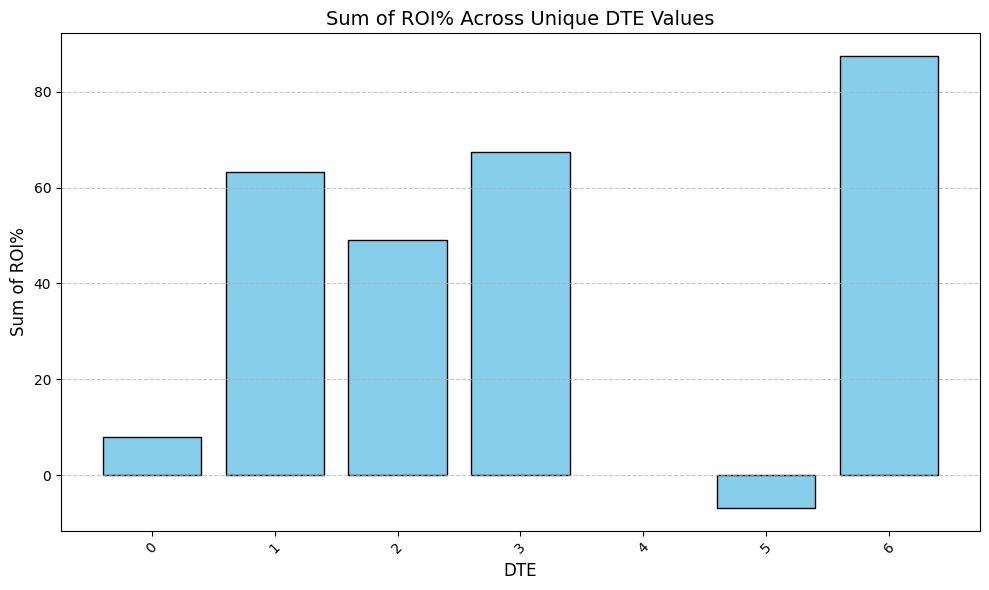

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sum_roi_by_dte(tb):
    """
    Plots the sum of ROI% across all unique DTE values.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.title('Sum of ROI% Across Unique DTE Values', fontsize=14)
    plt.xlabel('DTE', fontsize=12)
    plt.ylabel('Sum of ROI%', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# tb = pd.DataFrame({'DTE': [...], 'ROI%': [...]})  # Replace with your actual DataFrame
plot_sum_roi_by_dte(tb)


In [23]:
def calculate_max_dd(tb):
    """
    Calculates the maximum drawdown for each group of 'DTE'.
    
    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    
    Returns:
    pd.Series: Maximum drawdown for each unique DTE.
    """
    # Calculate cumulative sum of ROI%
    cumulative_returns = tb["ROI%"].cumsum()
    
    # Calculate maximum drawdown
    max_drawdown = (cumulative_returns - cumulative_returns.cummax()).min()
    
    return max_drawdown



Resulting DataFrame:
   DTE  Sum_ROI%  Max_DD%  ROI/DD_Ratio
0    0    8.0500   9.2900        0.8700
1    1   63.3200  16.4500        3.8500
2    2   49.0900  22.3200        2.2000
3    3   67.4200  15.3700        4.3900
4    5   -6.8500   5.7700       -1.1900
5    6   87.4800  16.0600        5.4500


/tmp/ipykernel_36420/3694656327.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()


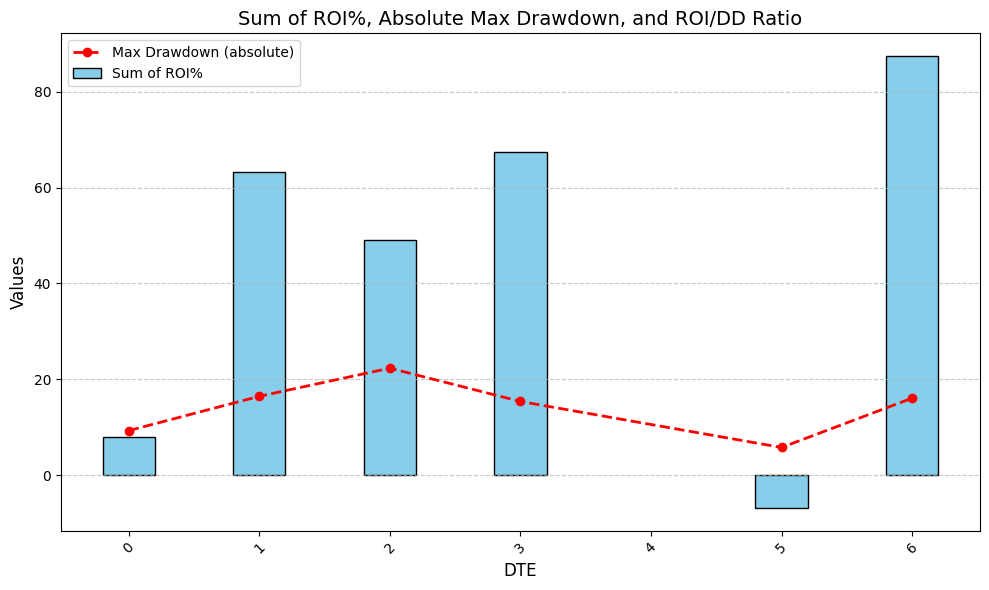

In [24]:
def plot_sum_roi_and_max_dd_by_dte(tb):
    """
    Plots the sum of ROI% and Absolute Max Drawdown (Max DD) across all unique DTE values
    using a single Y-axis, and prints the resulting DataFrame.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    roi_result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    roi_result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Group by DTE and calculate Max DD (in absolute terms)
    dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()
    dd_result.rename(columns={0: 'Max_DD%'}, inplace=True)
    dd_result['Max_DD%'] = dd_result['Max_DD%'].abs()

    # Merge the sum of ROI% and Max DD data
    result = pd.merge(roi_result, dd_result, on='DTE')

    # Add ROI% / Max DD ratio
    result['ROI/DD_Ratio'] = result.apply(
        lambda row: row['Sum_ROI%'] / row['Max_DD%'] if row['Max_DD%'] != 0 else float('inf'), axis=1
    )

    # Format values
    result['Sum_ROI%'] = result['Sum_ROI%'].round(2)
    result['Max_DD%'] = result['Max_DD%'].round(2)
    result['ROI/DD_Ratio'] = result['ROI/DD_Ratio'].round(2)

    # Print the DataFrame
    print("\nResulting DataFrame:")
    print(result)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Sum of ROI%
    ax.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black', label='Sum of ROI%', width=0.4, align='center')
    
    # Overlay Max DD (absolute values) on the same axis
    ax.plot(result['DTE'], result['Max_DD%'], color='red', marker='o', label='Max Drawdown (absolute)', linestyle='--', linewidth=2)

    ax.set_xlabel('DTE', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Title, legend, and grid
    plt.title('Sum of ROI%, Absolute Max Drawdown, and ROI/DD Ratio', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    fig.tight_layout()
    plt.show()

plot_sum_roi_and_max_dd_by_dte(tb)
